# Predicting Labels 

We continue our analysis analyzing the language that best predicts the specific labels. We will use the labels generated in the `explore_clean_setup.ipynb` notebook using the likert scale values submitted by reviewers. We will use [sklearns TfidfVectorizer (Term frequency–inverse document frequency vectorizer)](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to identify the words that are most predictive of each label. TFIDF is a method for counting the relative frequency of terms in a corpus and will provide us a straight forward baseline of which words and phrases are most predictive of a given label.  

In [1]:
import os 
import bear_necessities as bn
import pandas as pd 
import numpy as np
import random 
from gensim.models import KeyedVectors
import modeling_tools_v2 as mt
import visuals as vs 
from importlib import reload
# set the random generator seed 
random.seed(10)

C:\Users\carlo\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


*Load the data:*

In [2]:
# load the cleaned text data
text, stem_map, lemma_map, phrase_frequencies = bn.decompress_pickle(os.getcwd()+'/data/cleaned_data/cleaned_docs_A1.pbz2')

# import the labels indices 
label_dict = bn.decompress_pickle(os.getcwd()+'/data/labeled_indices.pbz2')   

For simplicity's sake, our labels are binary. We will submit each one to a logistic regression model for classification once they have been vectorized. We would like a balanced sample of 1's and 0's for our labels. Since every label is a minority in the corpus we will randomly sample reviews that are not under the given label. In fact, because we do not know the degree to which two values of the same characteristic (i.e. Easiness 1 & Easiness 2) share the same language, we will also remove all non-5 indices from the pool of available indices for drawing 0's. 

In [3]:
negative_dict = {} 
# for each set of label indices retrieve a sample of indices of equal size that do not share that label. 
for k in label_dict:
    negative_dict[k] = {} 
    # we will hold all the non-five indices under this characteristic 
    character_indices = []
    for v in label_dict[k]:
        # we exclude characteric values of "5" because these are considered default and less informative 
        if v !=5: 
            character_indices+= label_dict[k][v]
    # now that we have collected all the non-five indices under this characteristic we can loop through again and draw 0's 
    for v in label_dict[k]:
        if v!=5: 
            # add an entry with a random sample from the indices that are not in the character of the size of the label 1's 
            negative_dict[k][v] = random.sample(list(np.setdiff1d(range(0,len(text)),character_indices)), len(label_dict[k][v]))  

## TFIDF & SVMS 

So many acronyms!!! After transforming the text into vectors we will use a supervised learning model called [support vector machines](https://scikit-learn.org/stable/modules/svm.html) to predict text labels using the transformed data. For TFIDF we will use the data that was cleaned most extensively. Since our goal is explanation and not prediction there will be no need to separate the data out into training and test sets.

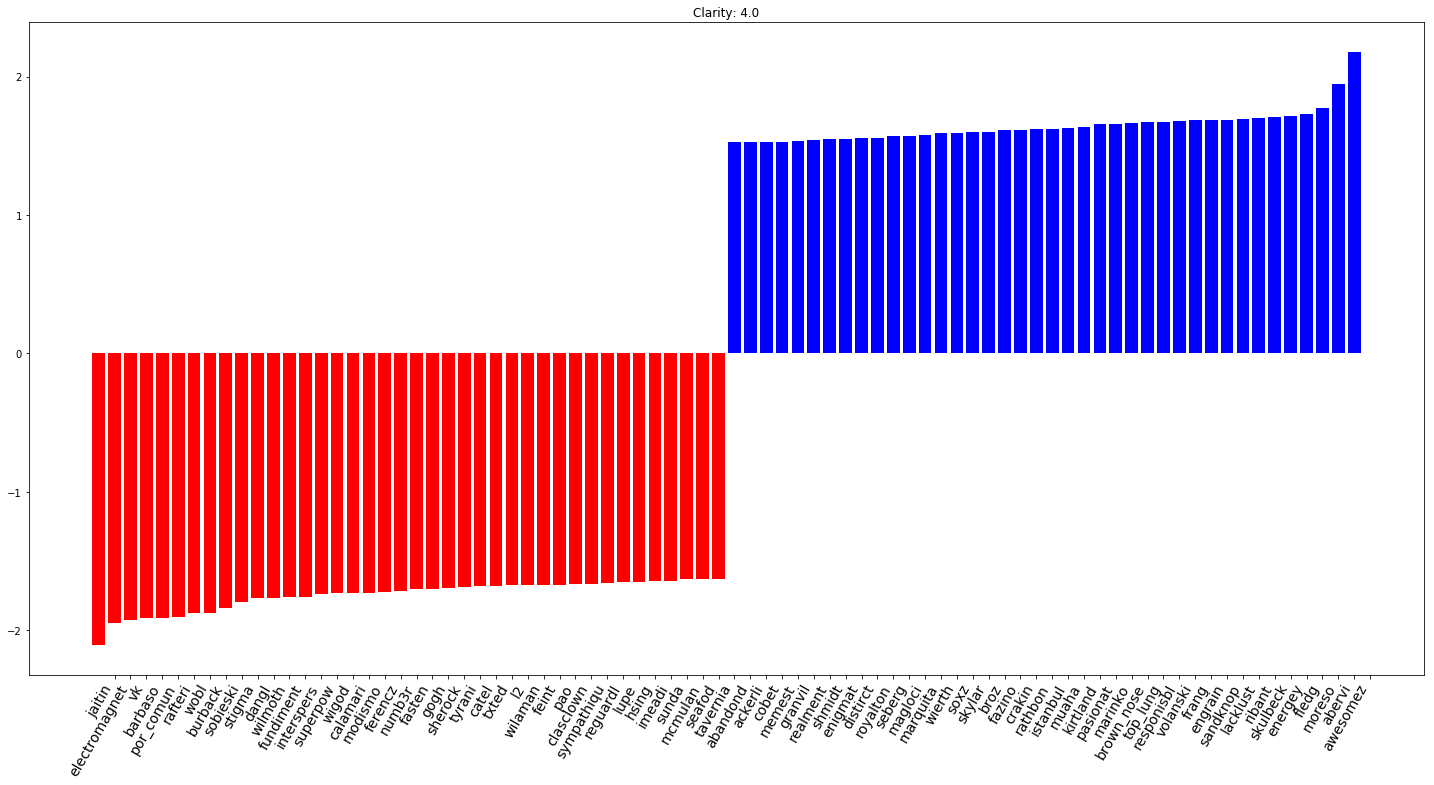

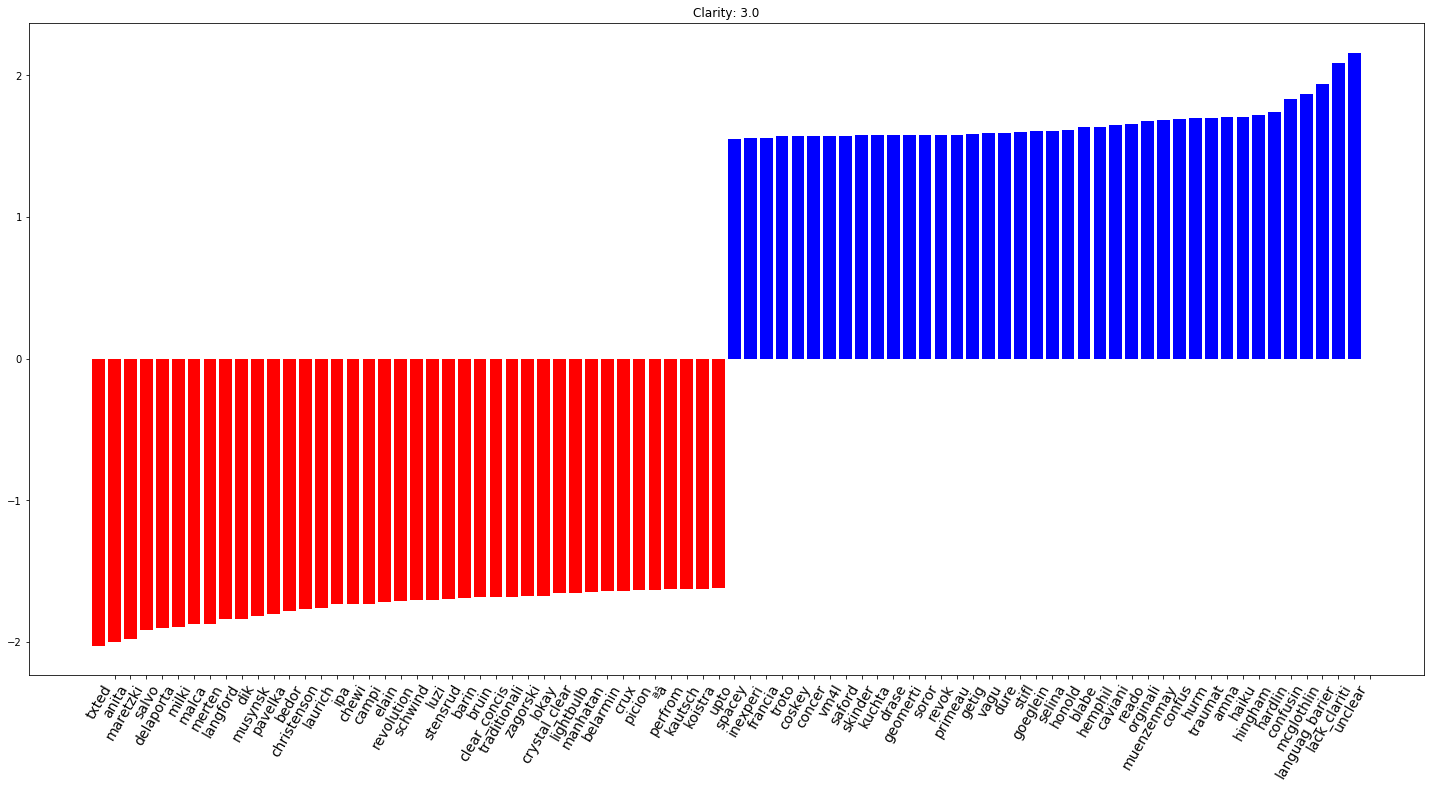

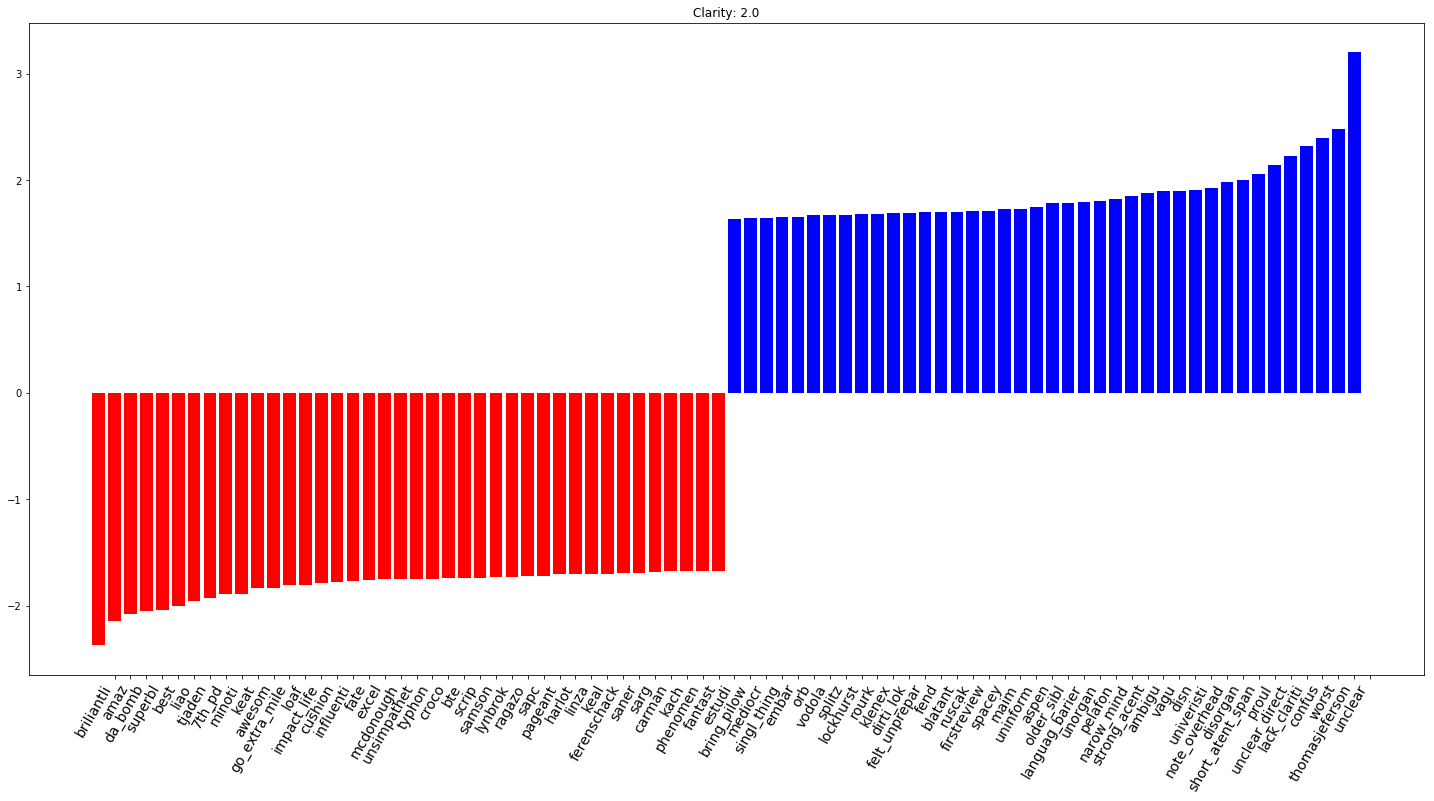

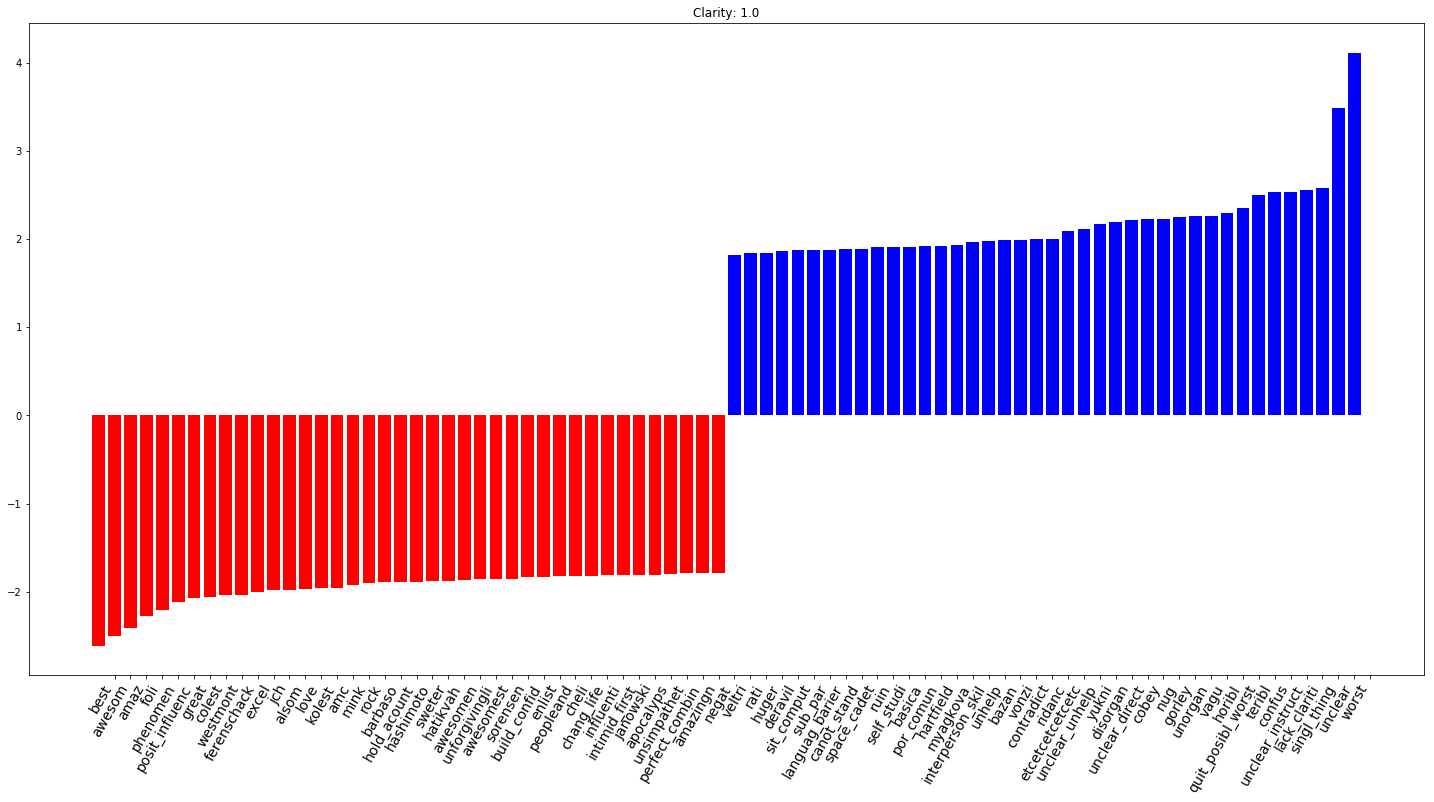

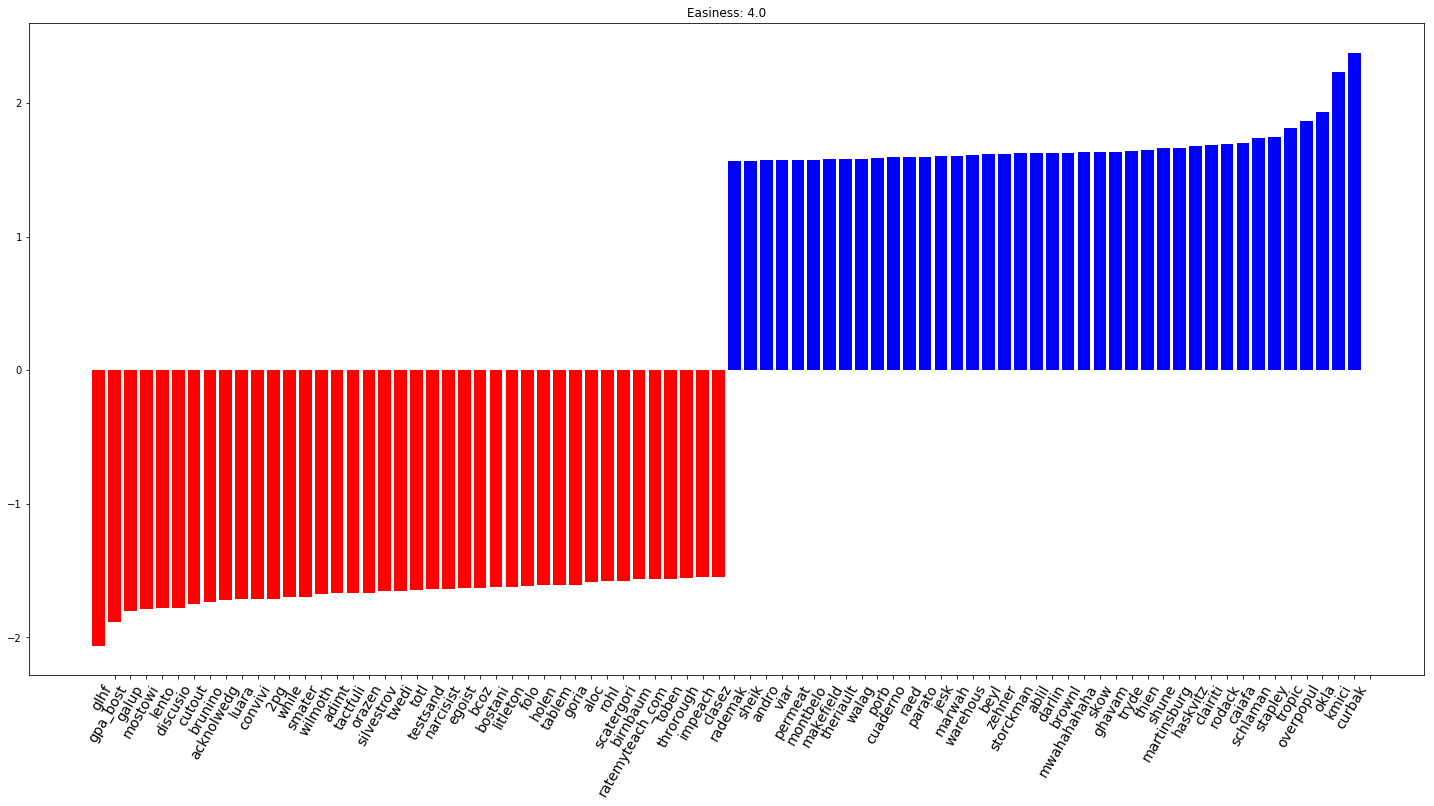

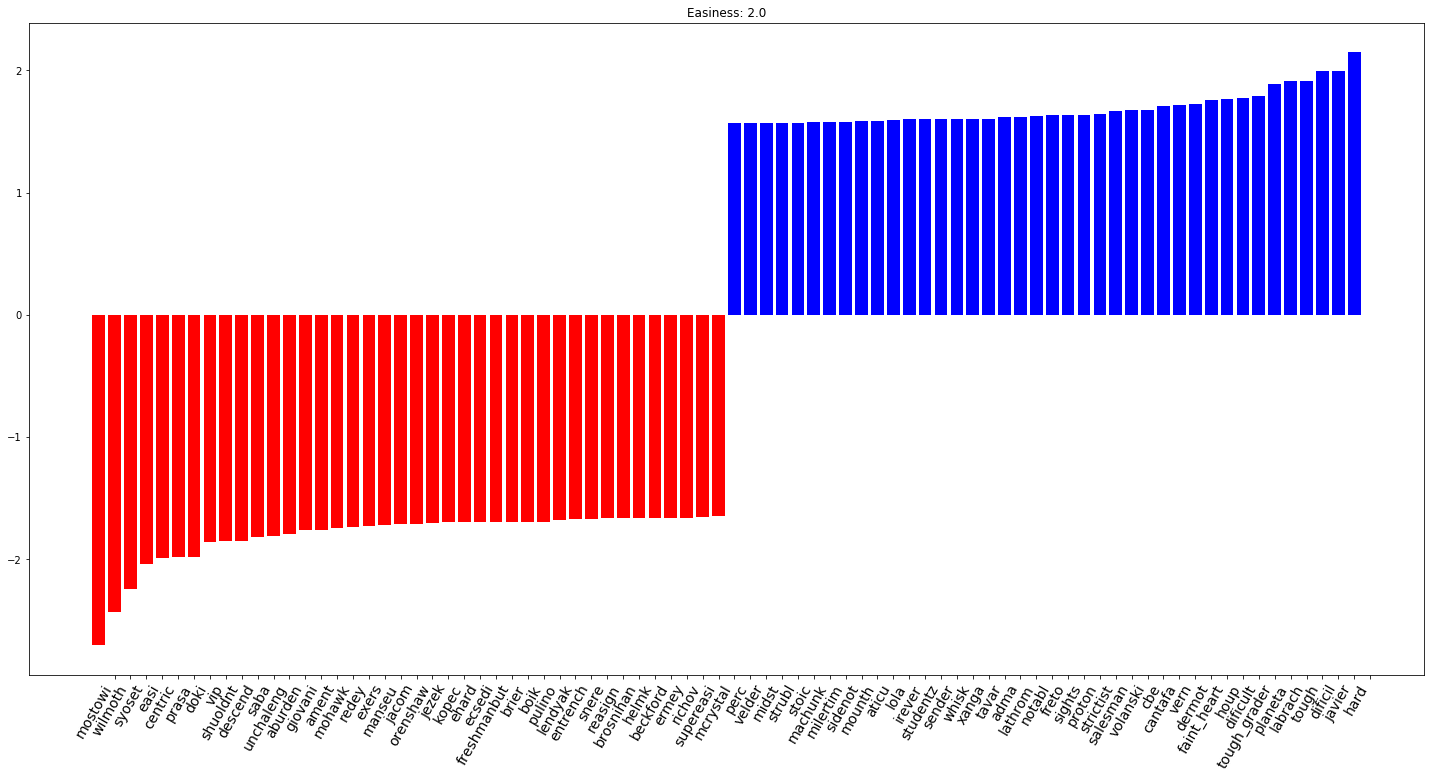

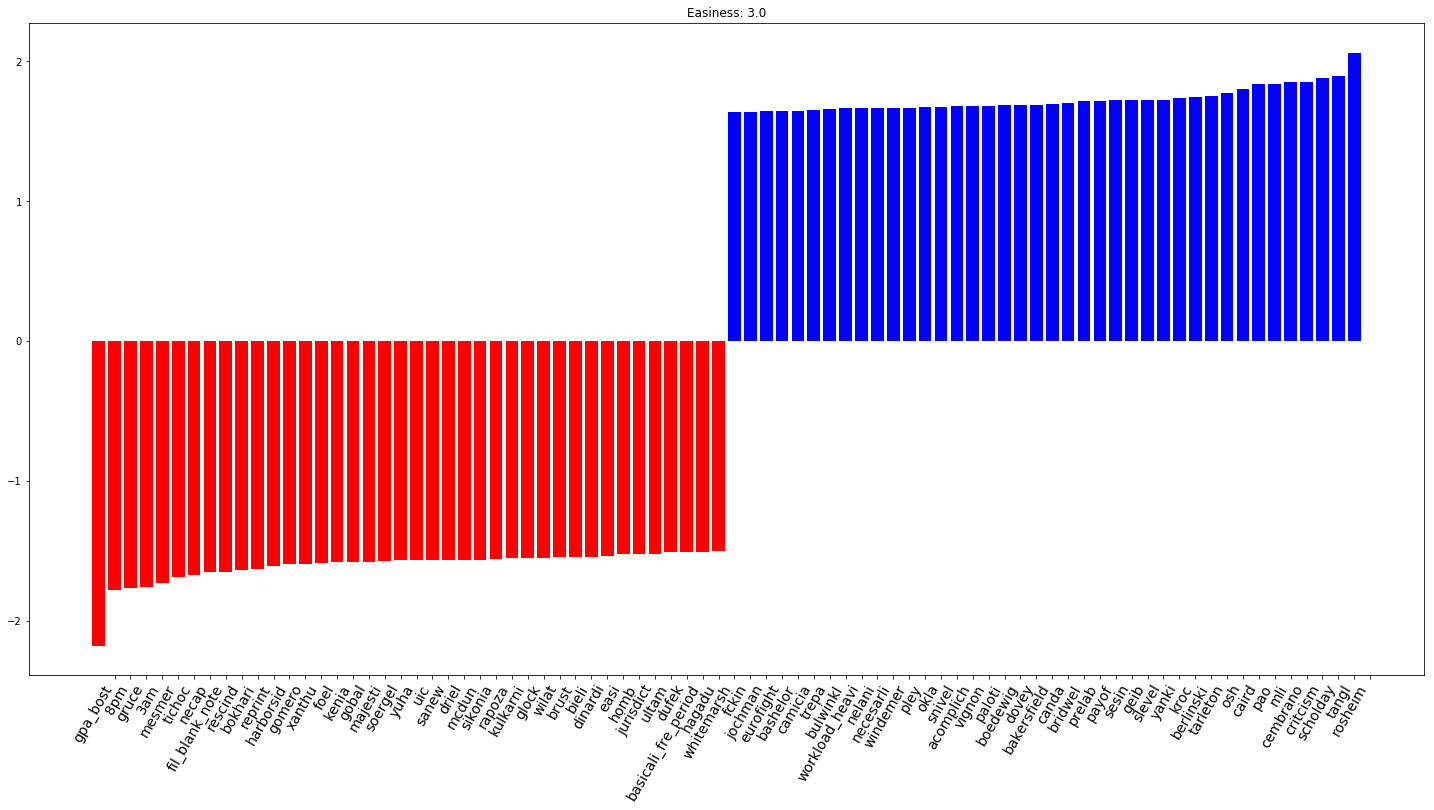

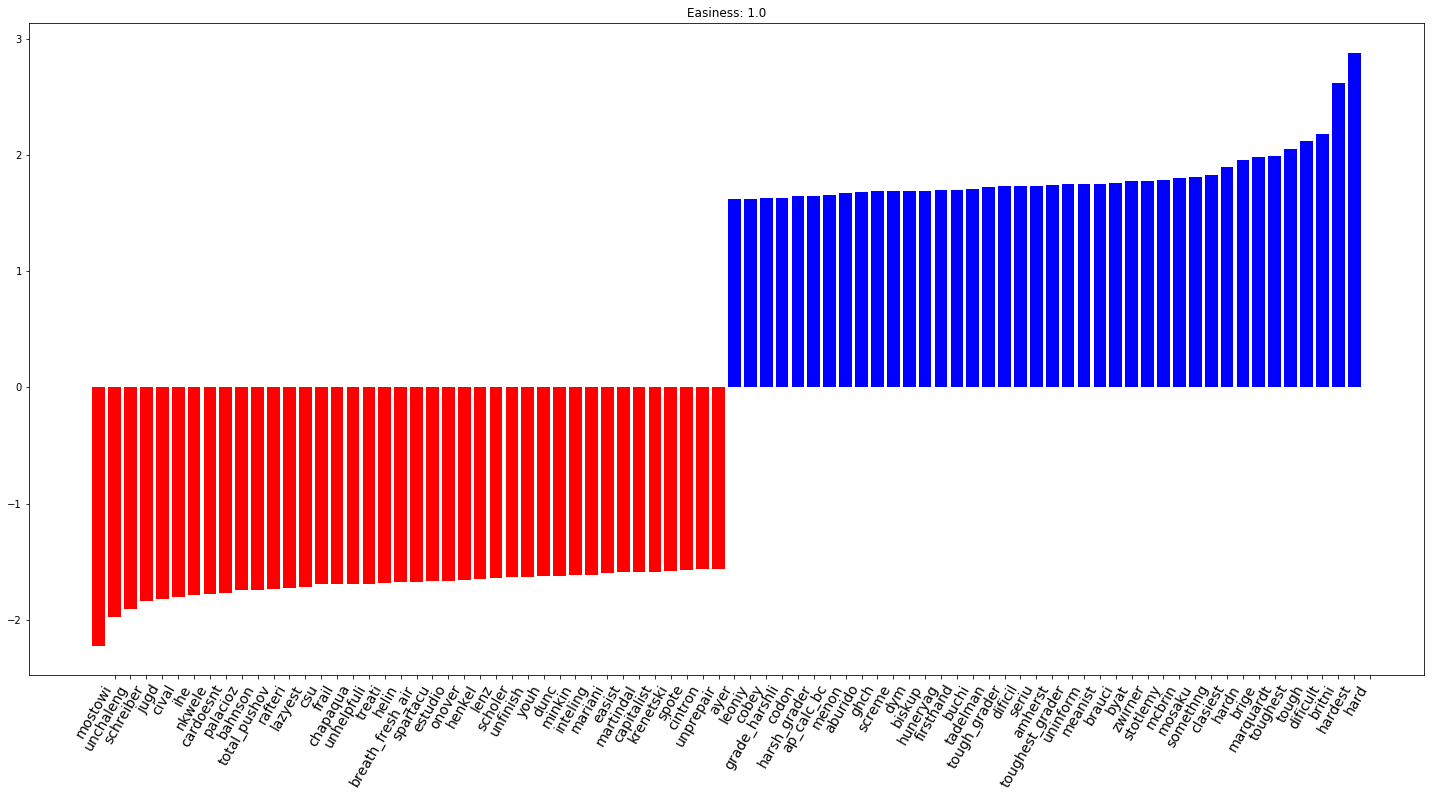

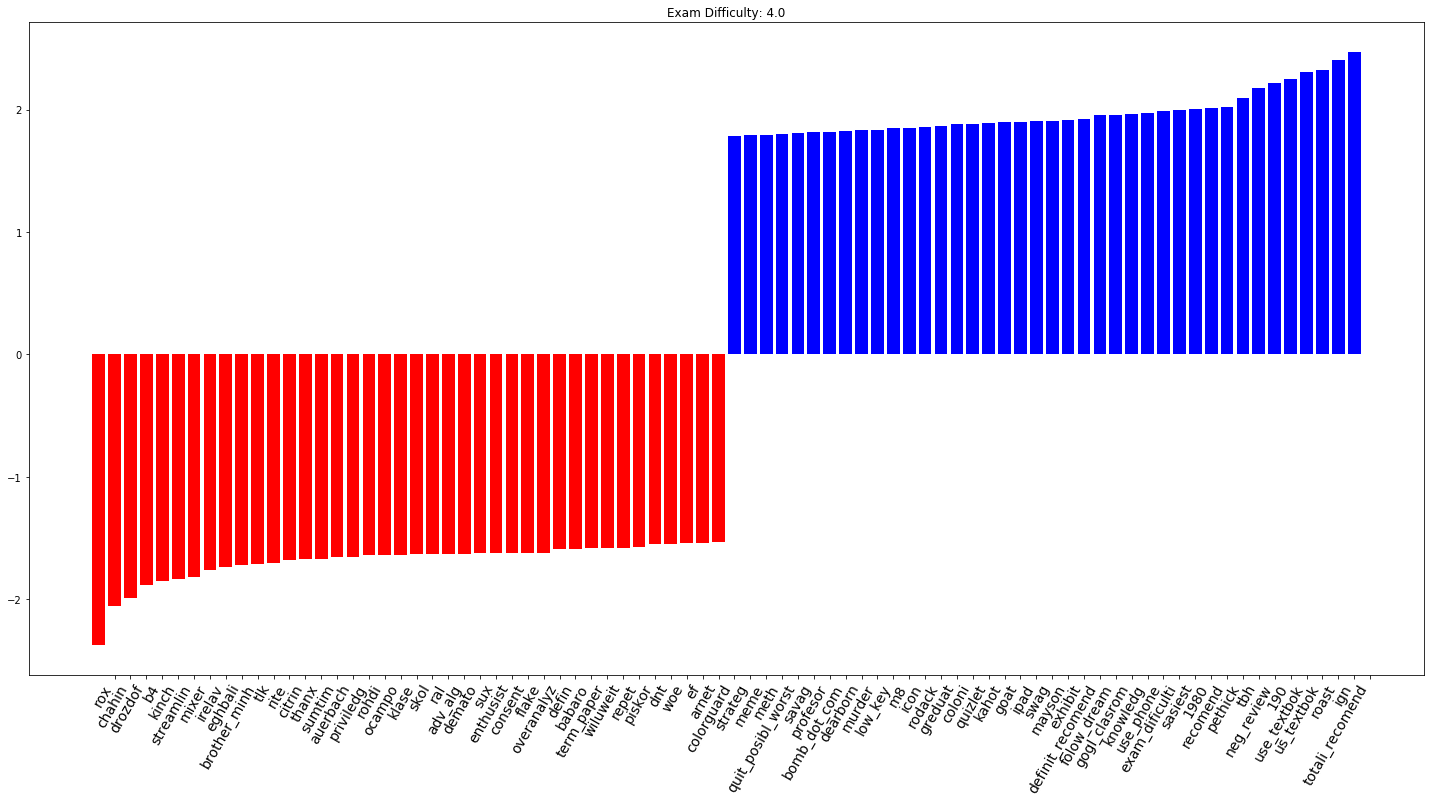

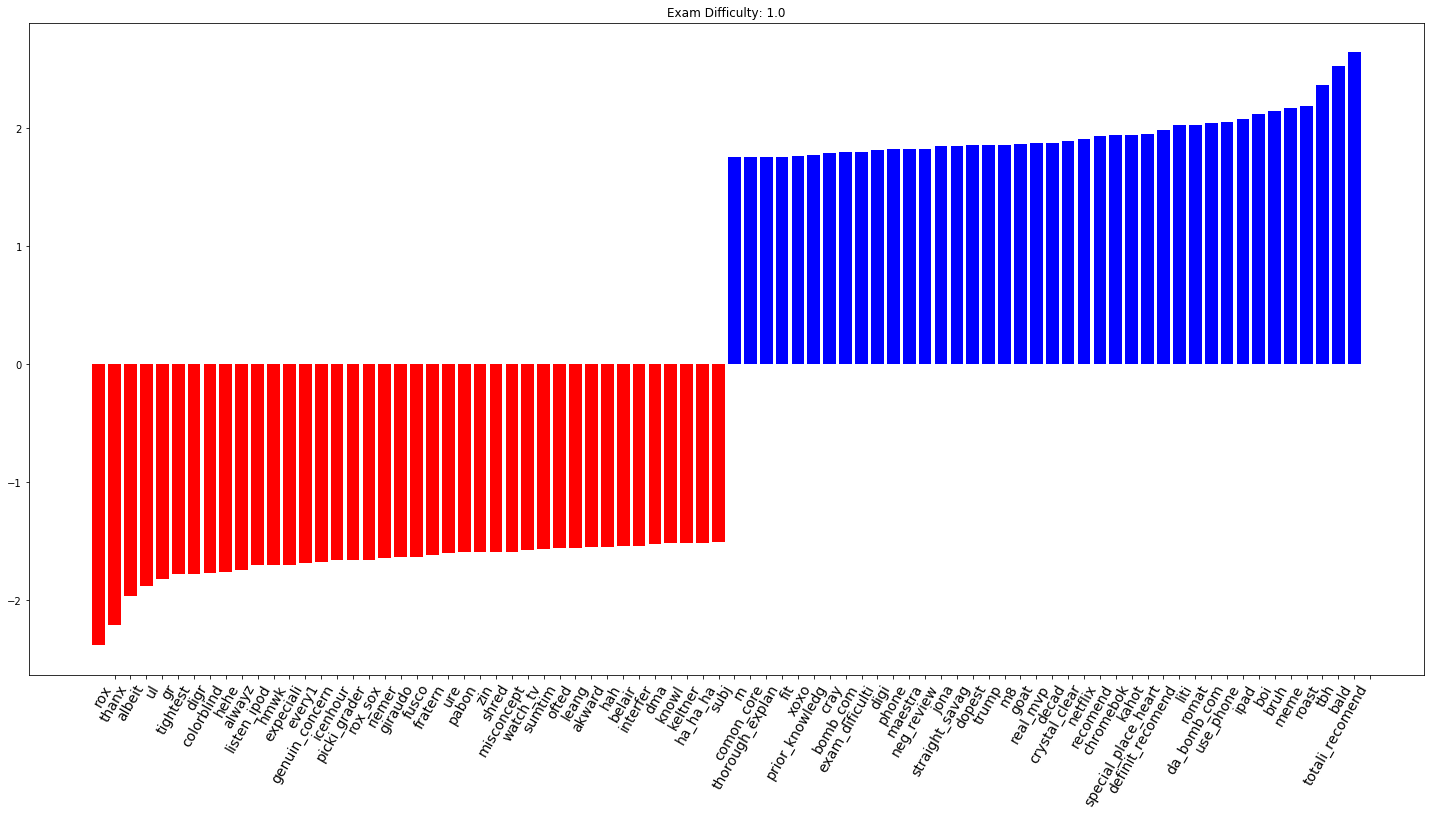

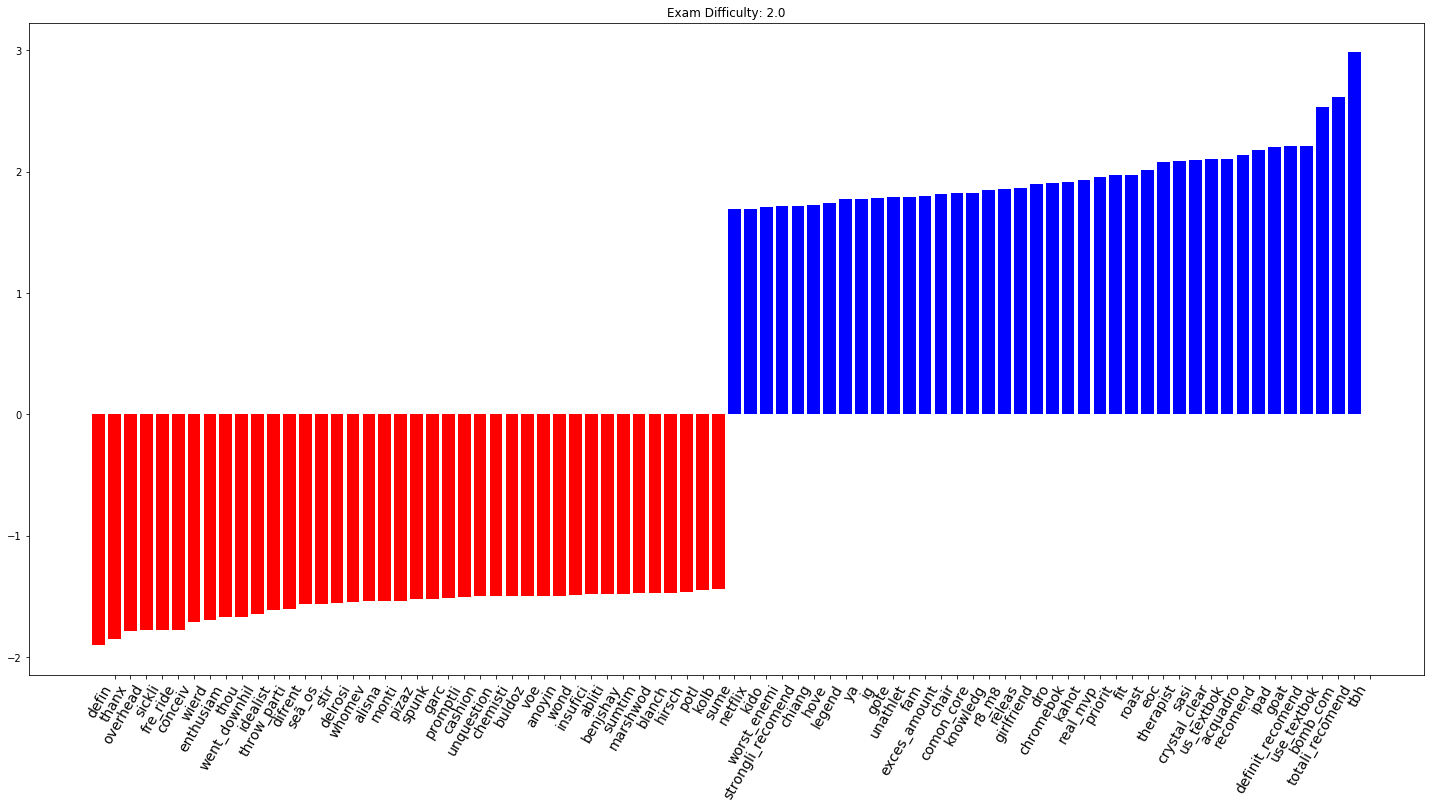

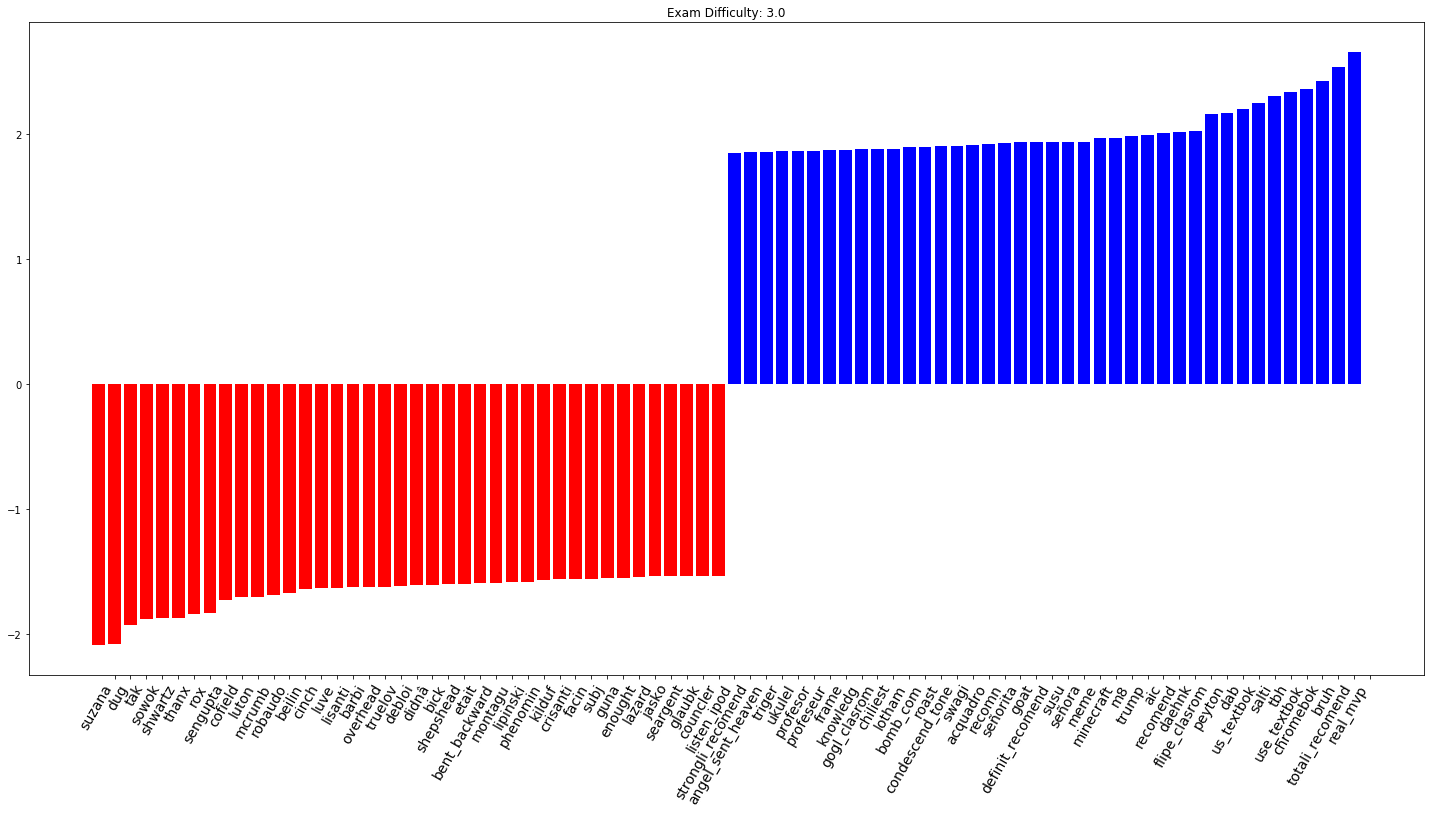

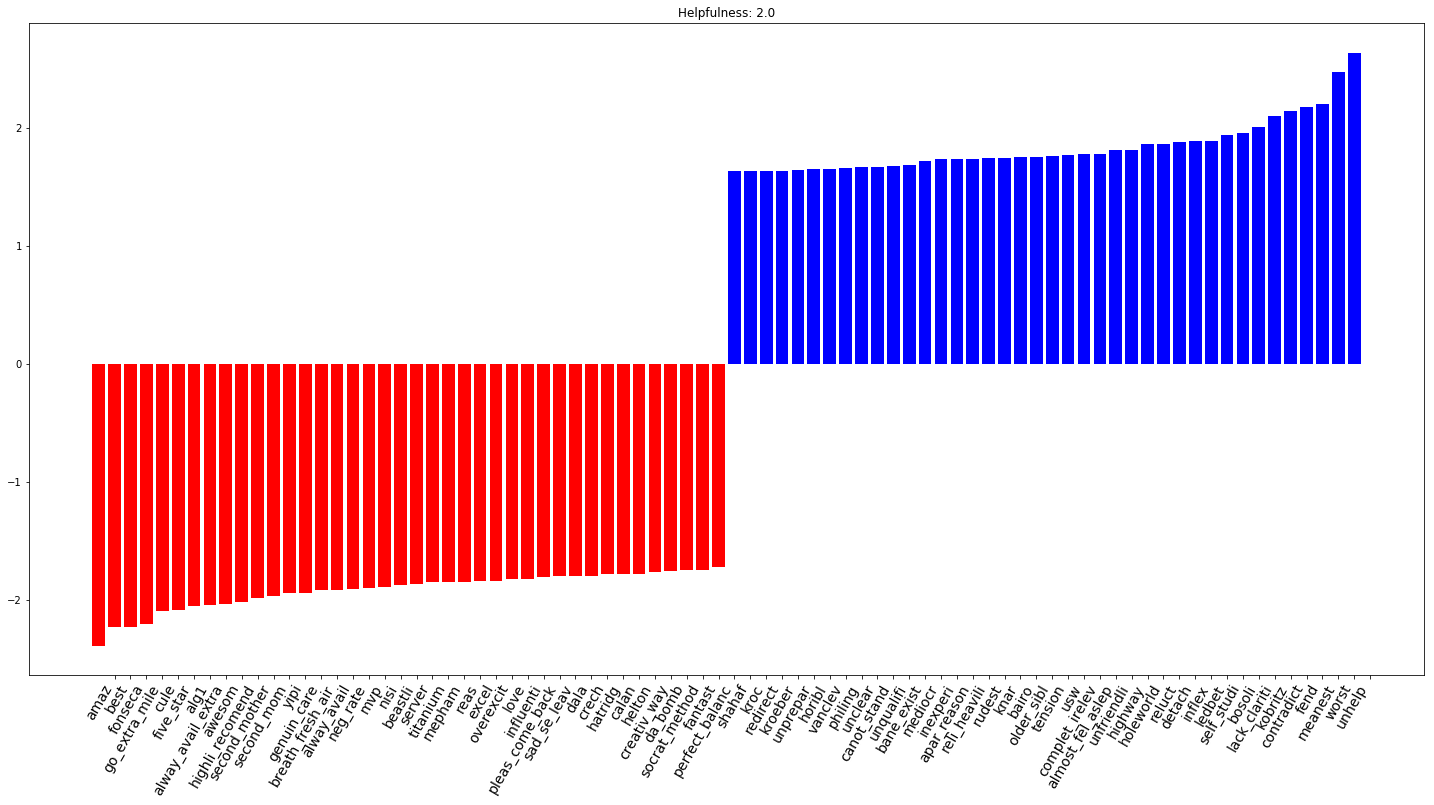

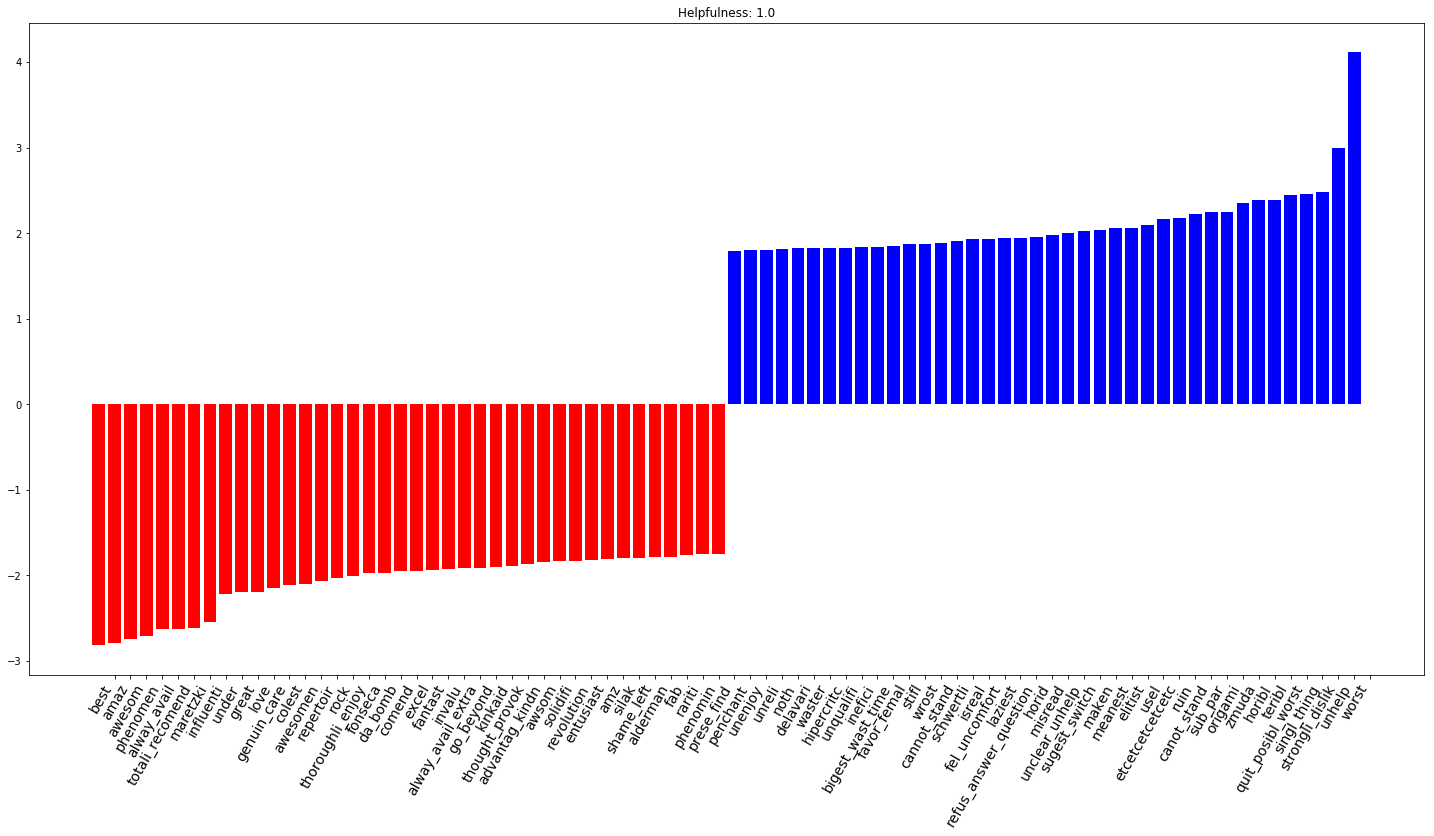

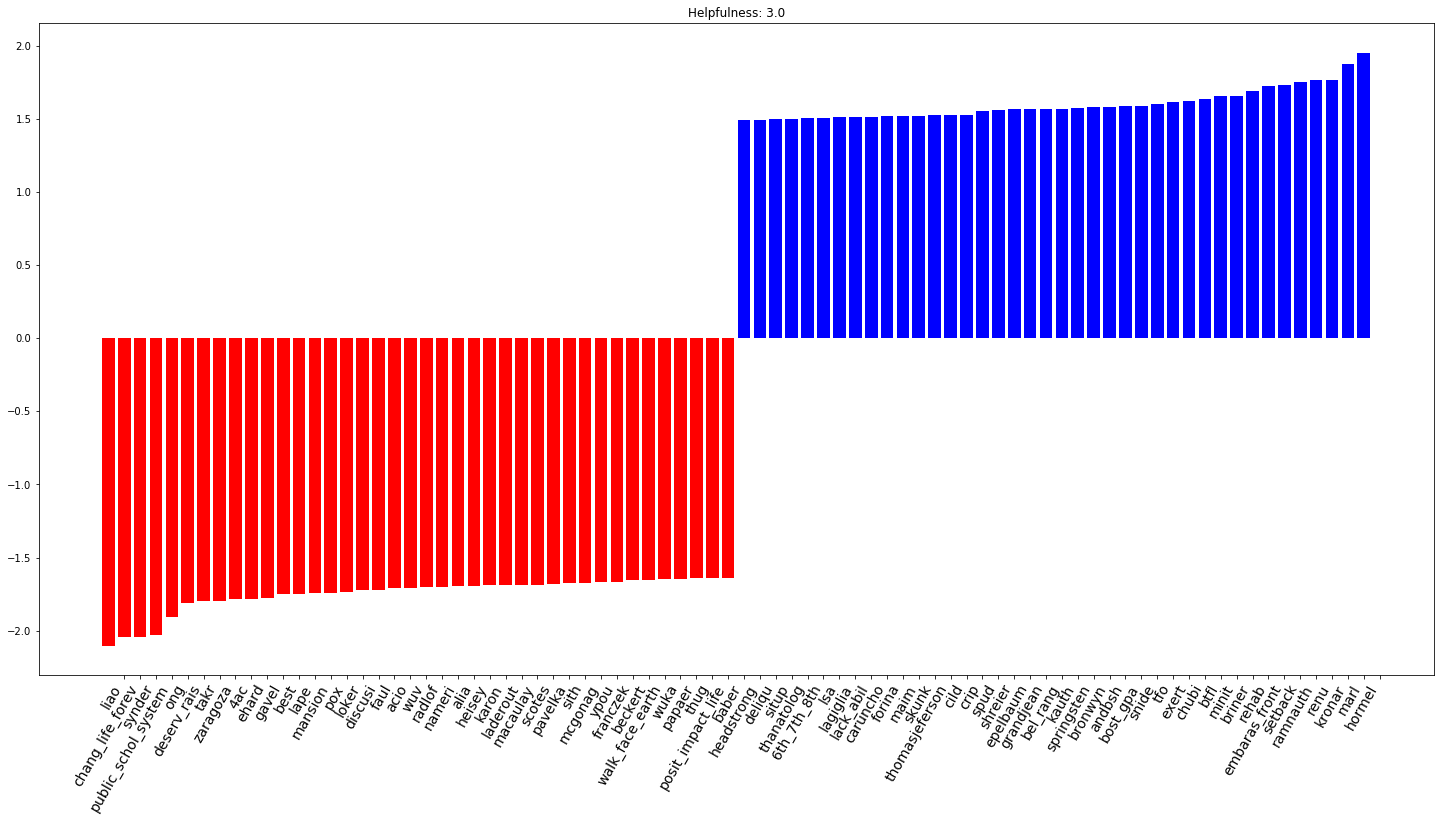

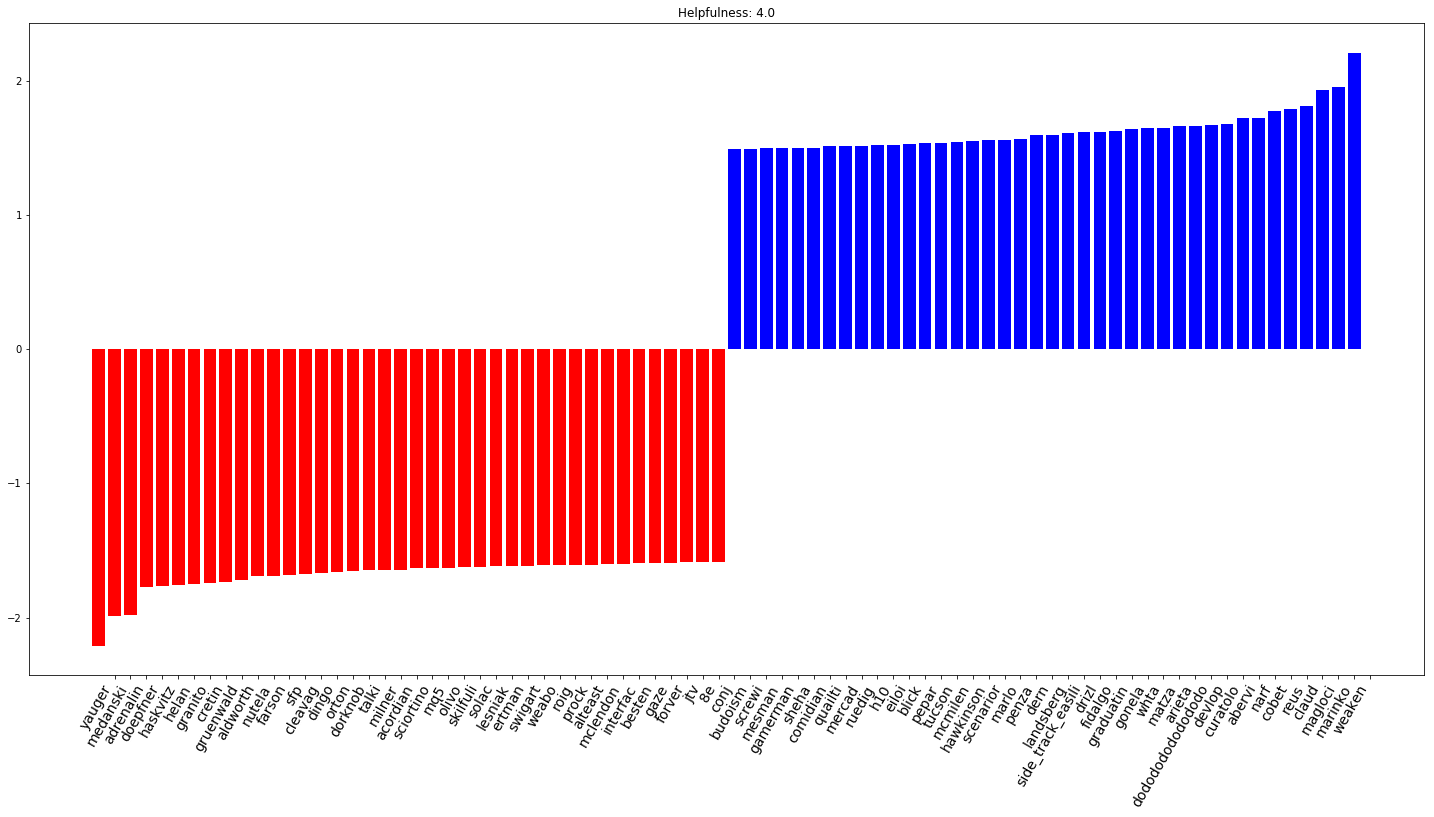

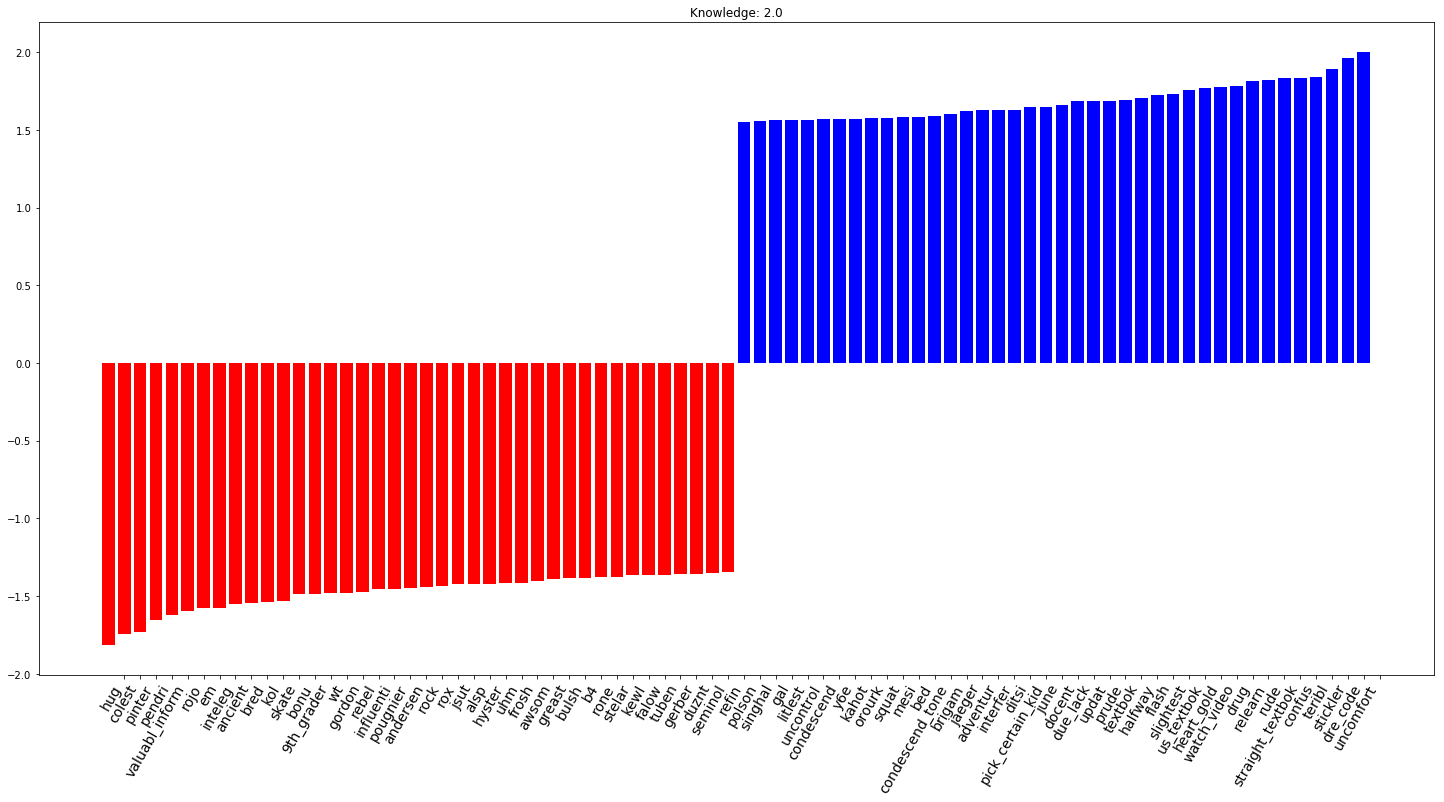

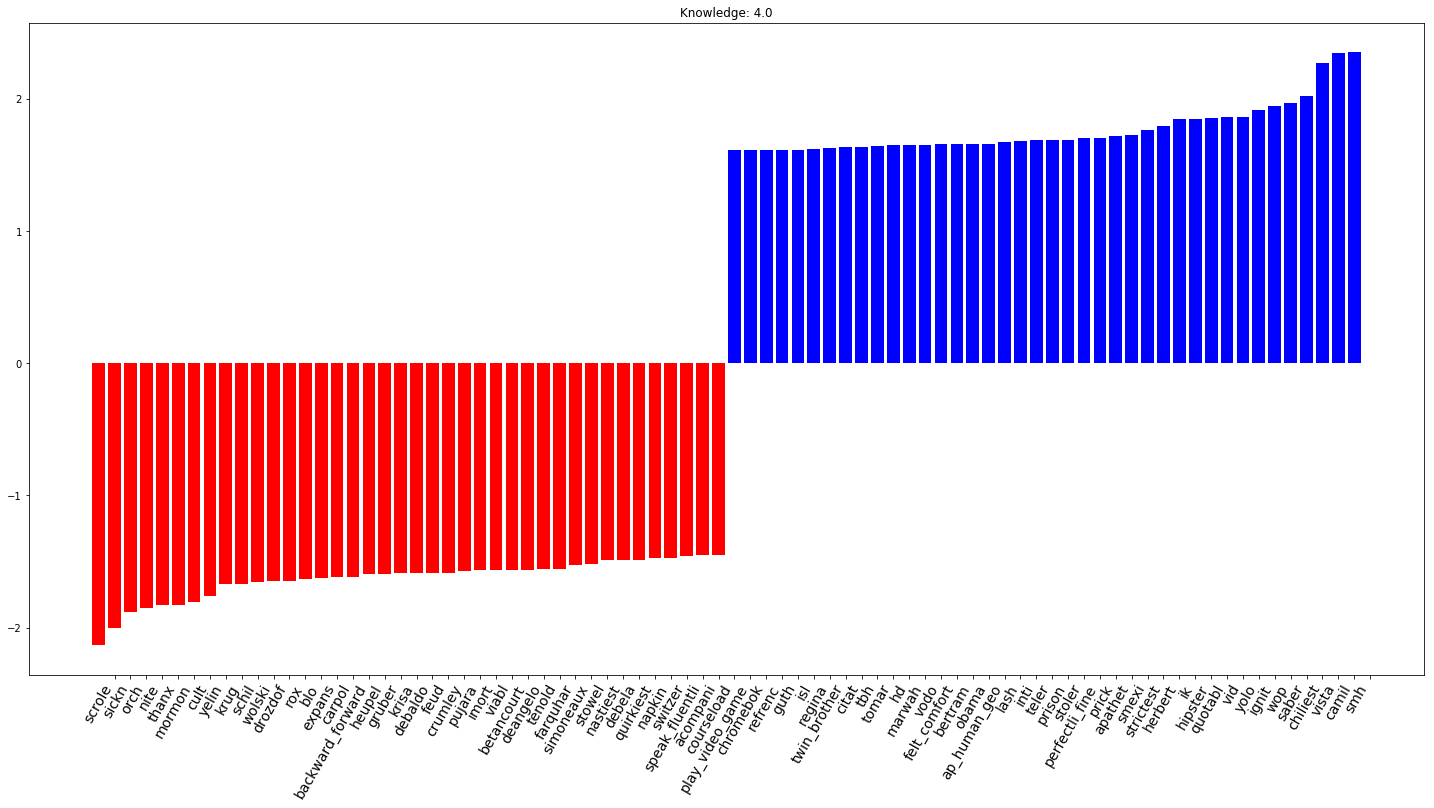

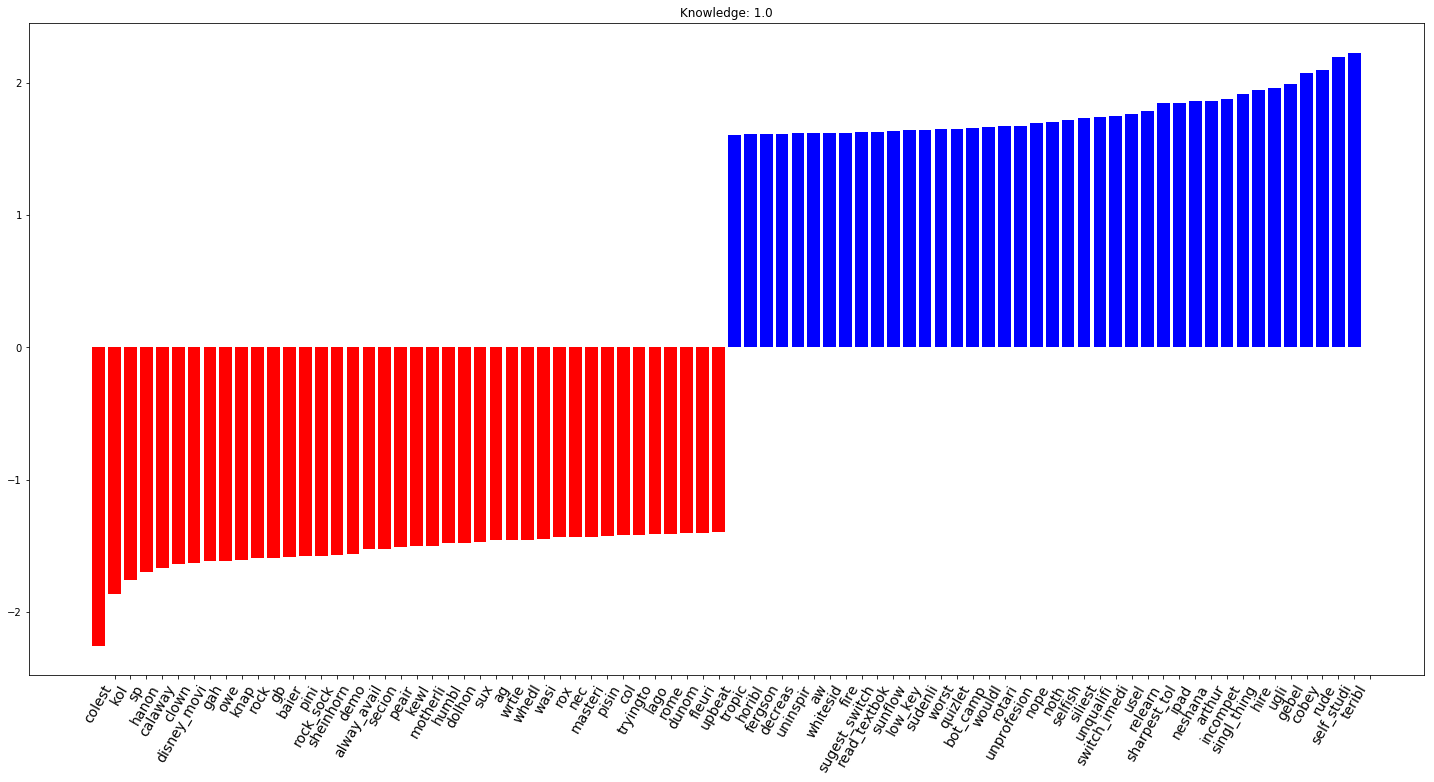

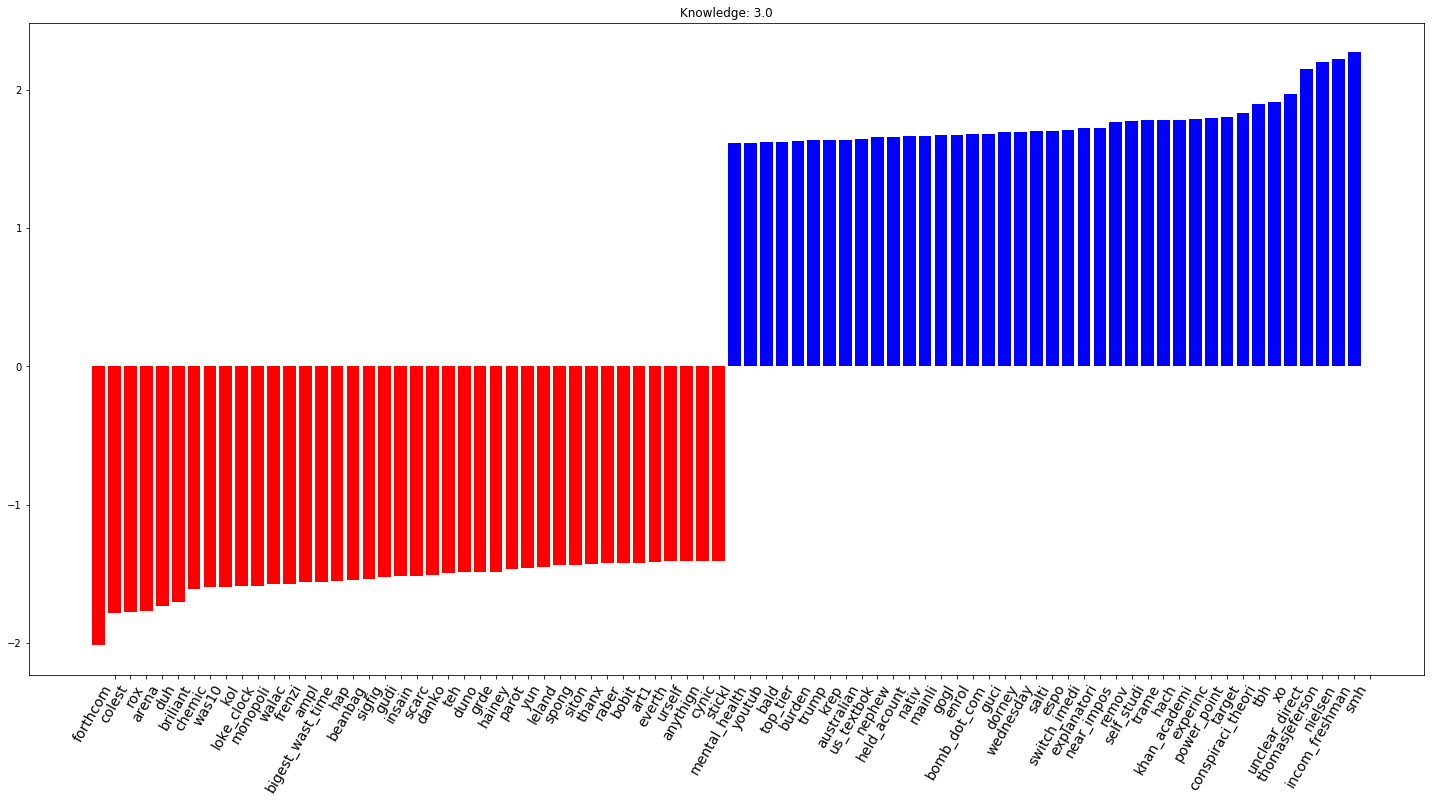

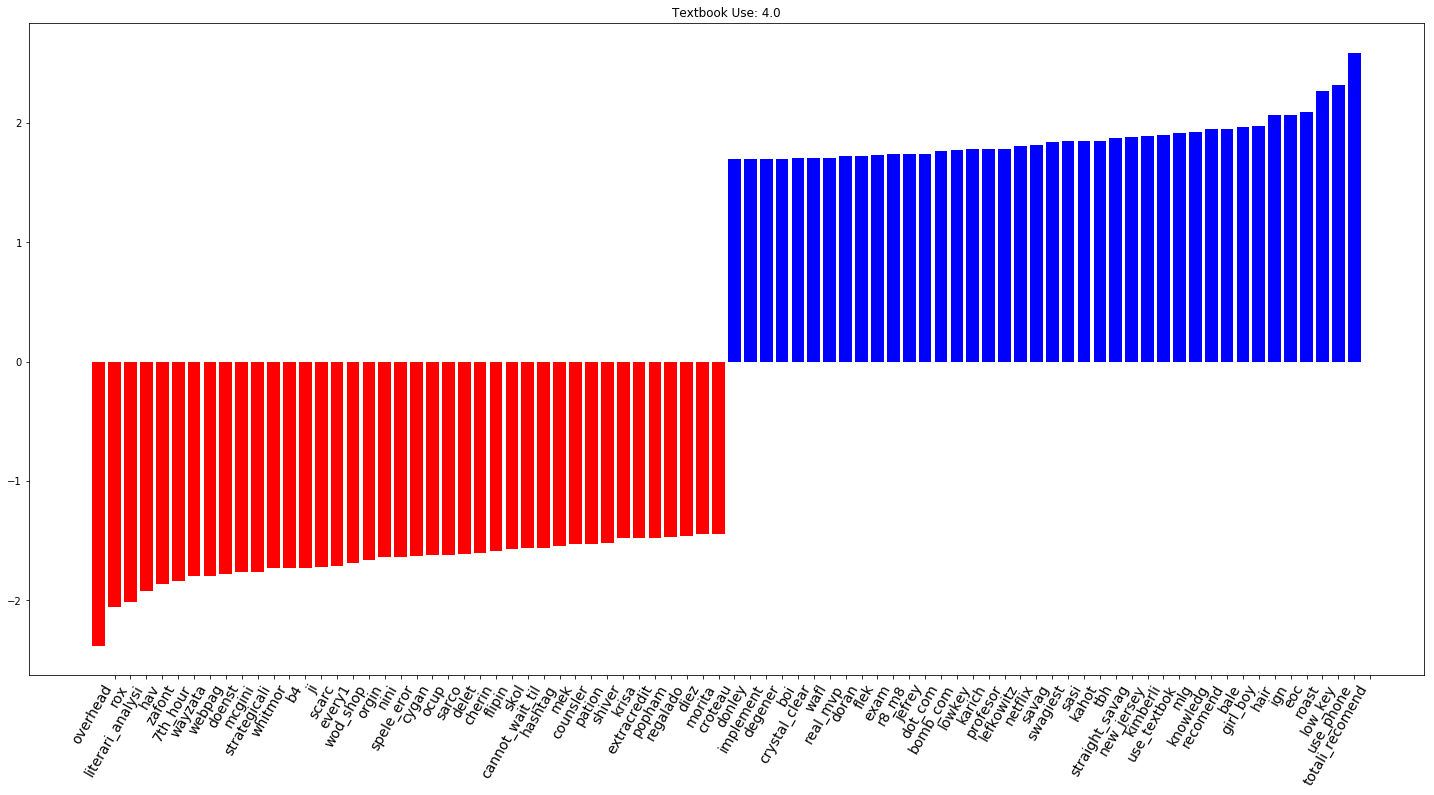

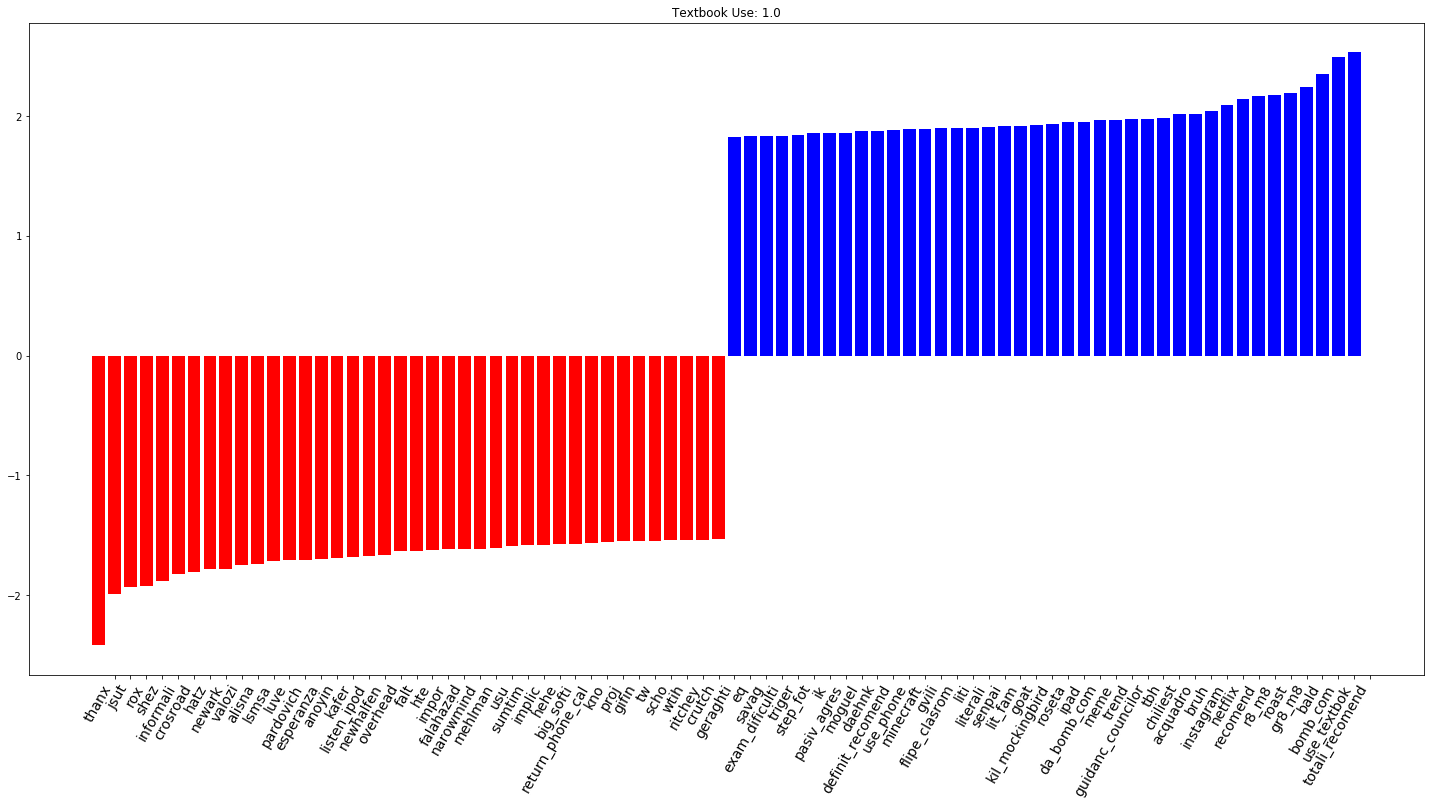

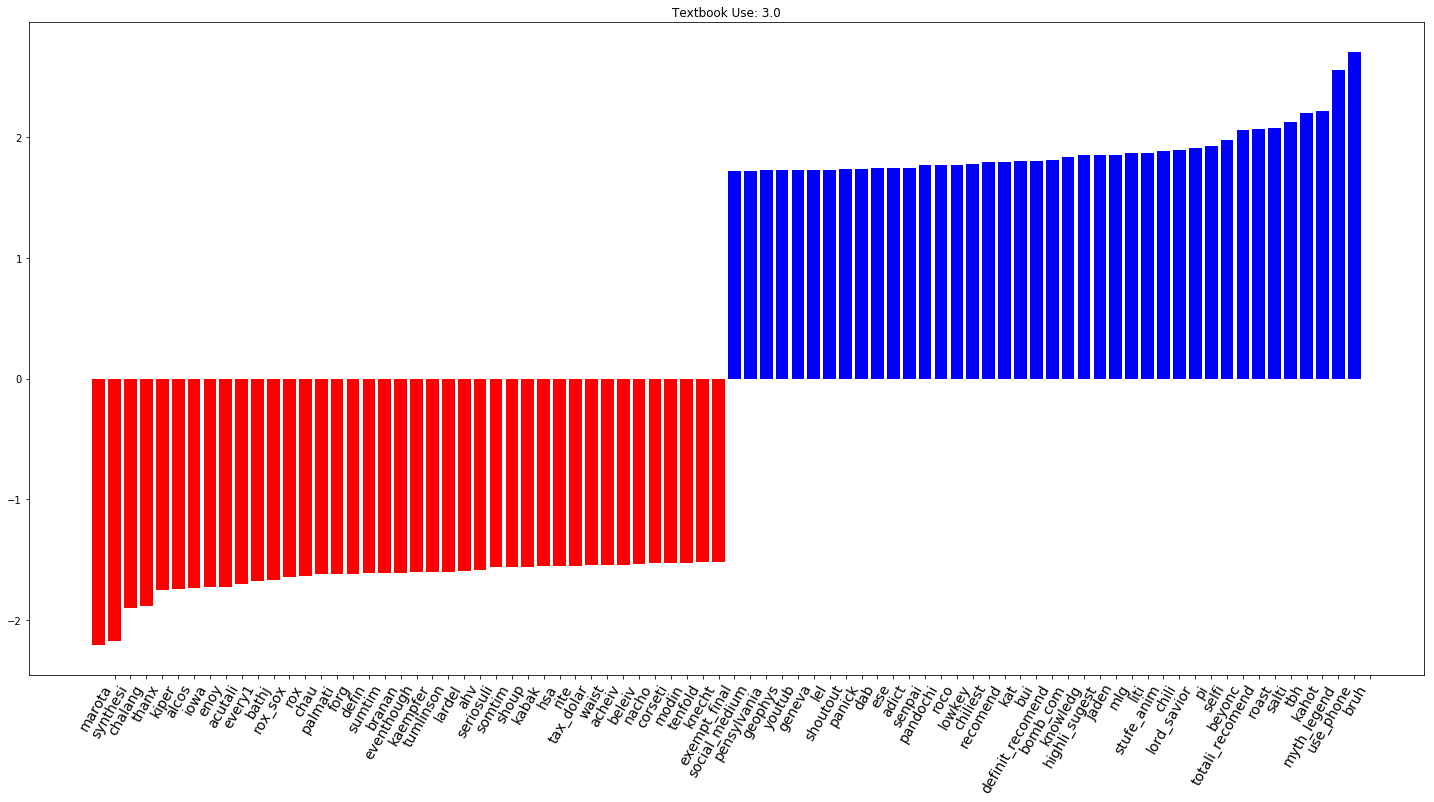

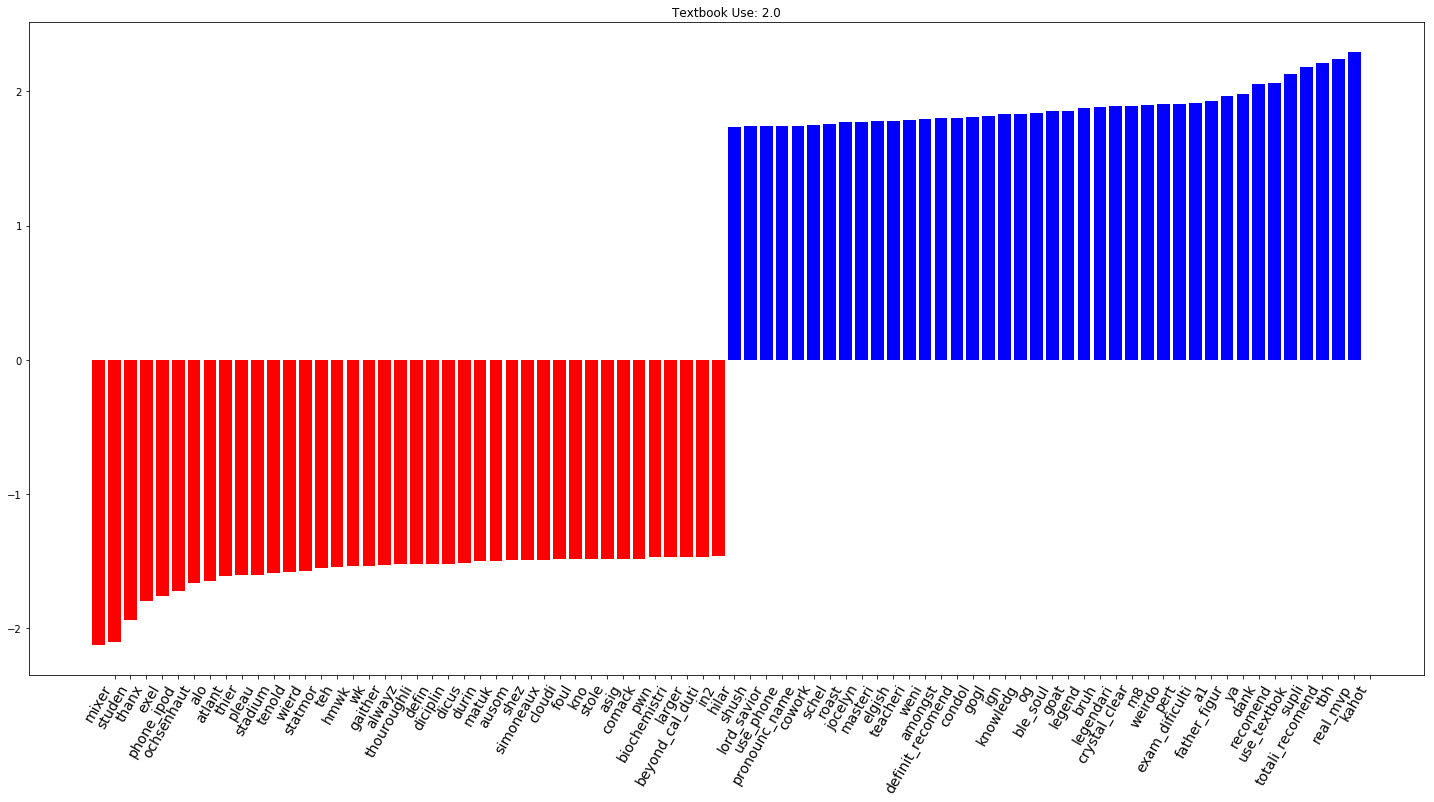

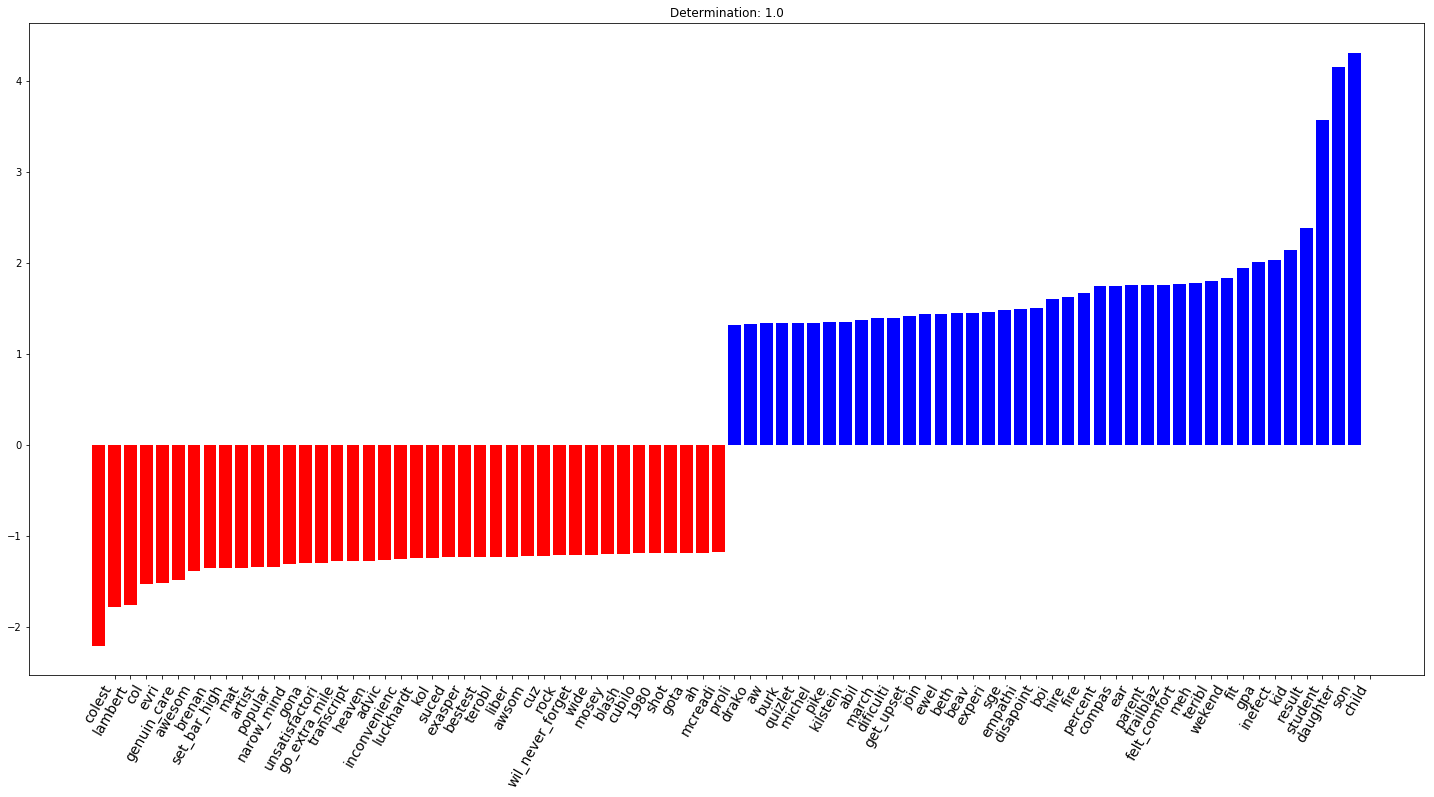

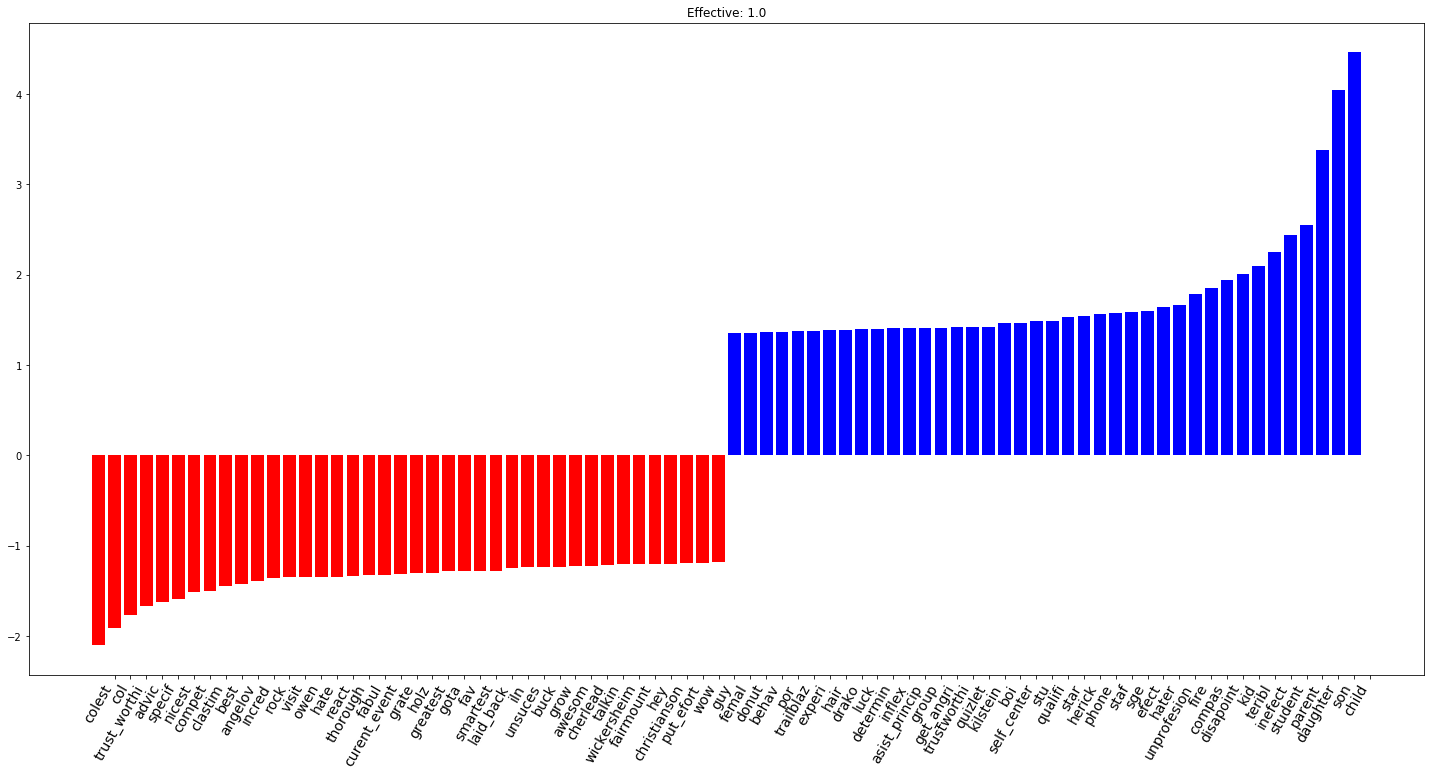

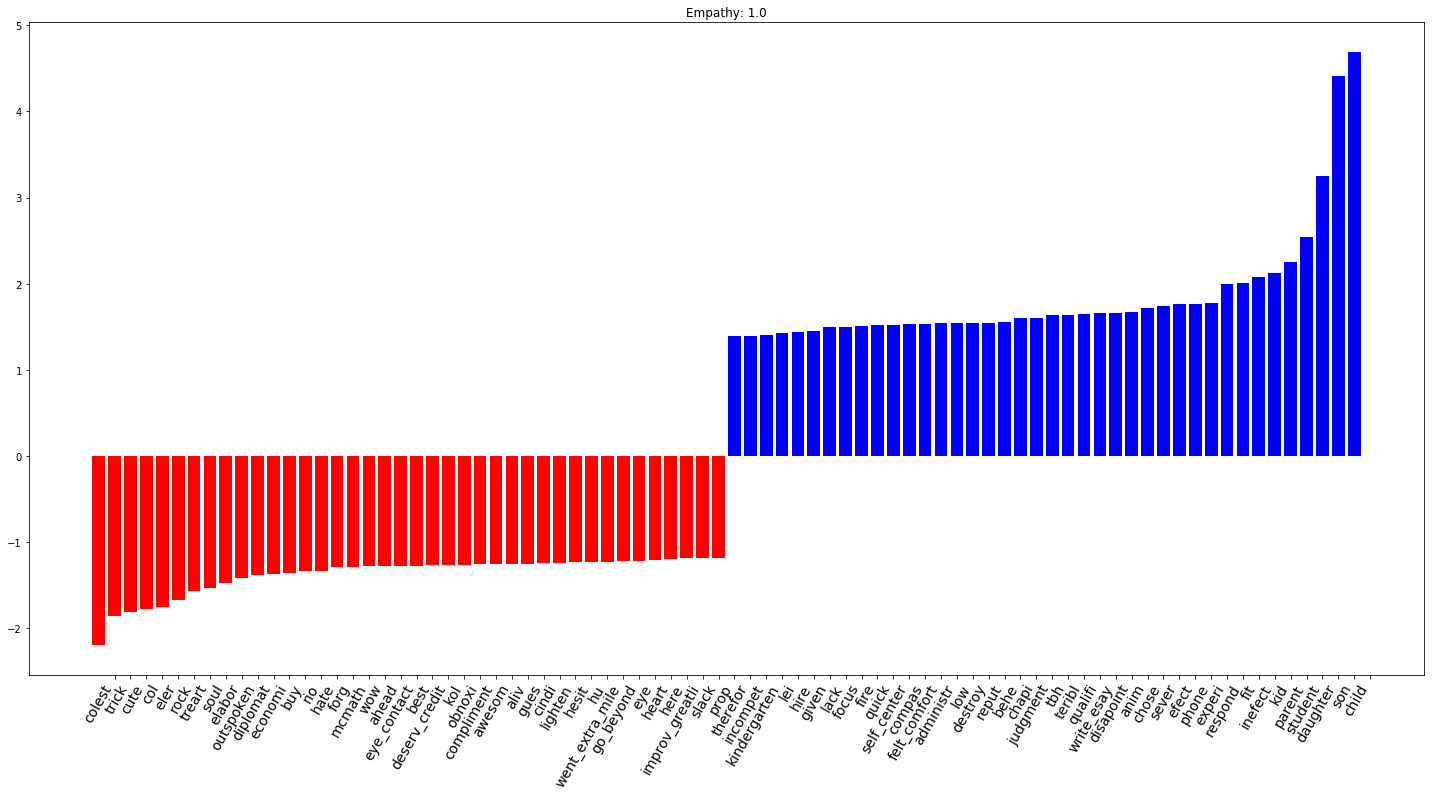

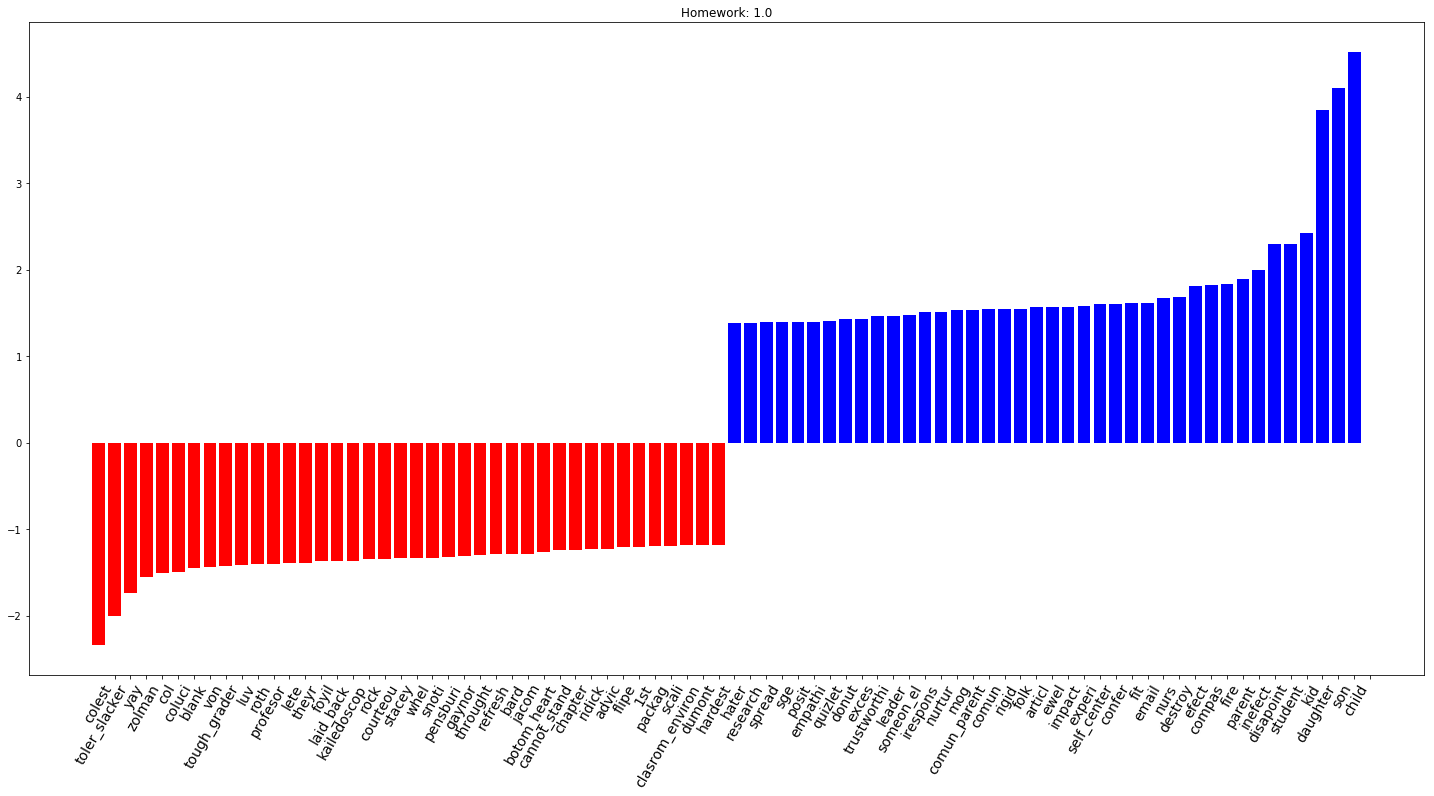

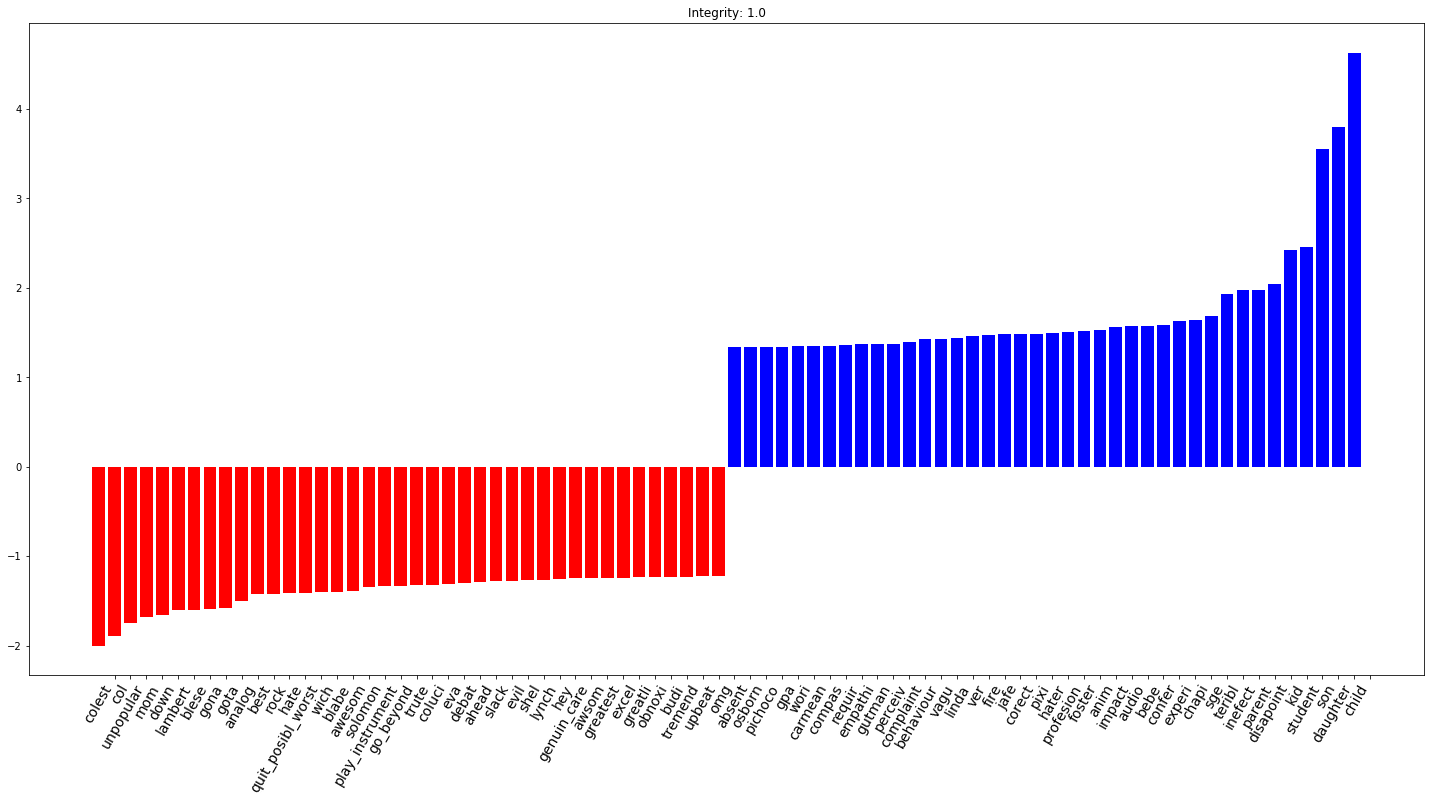

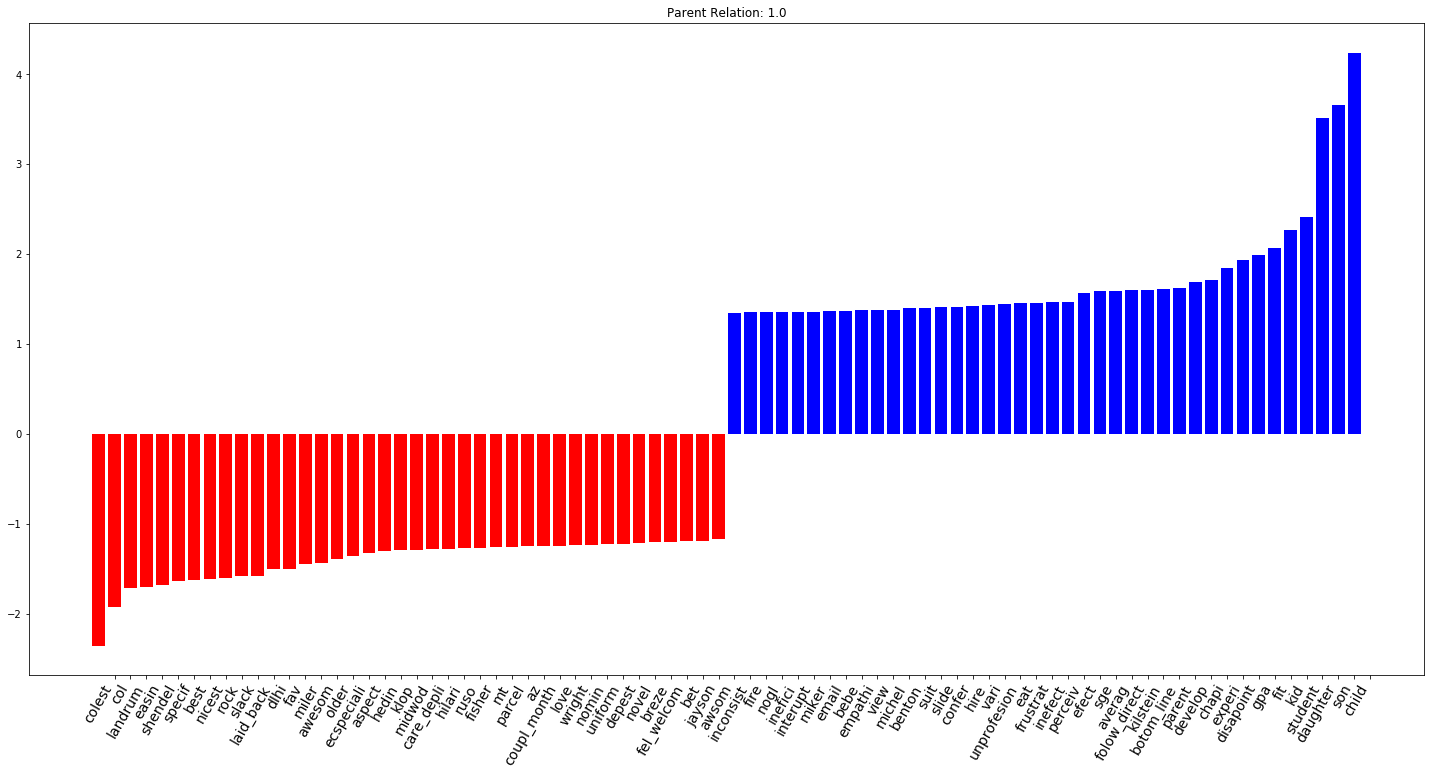

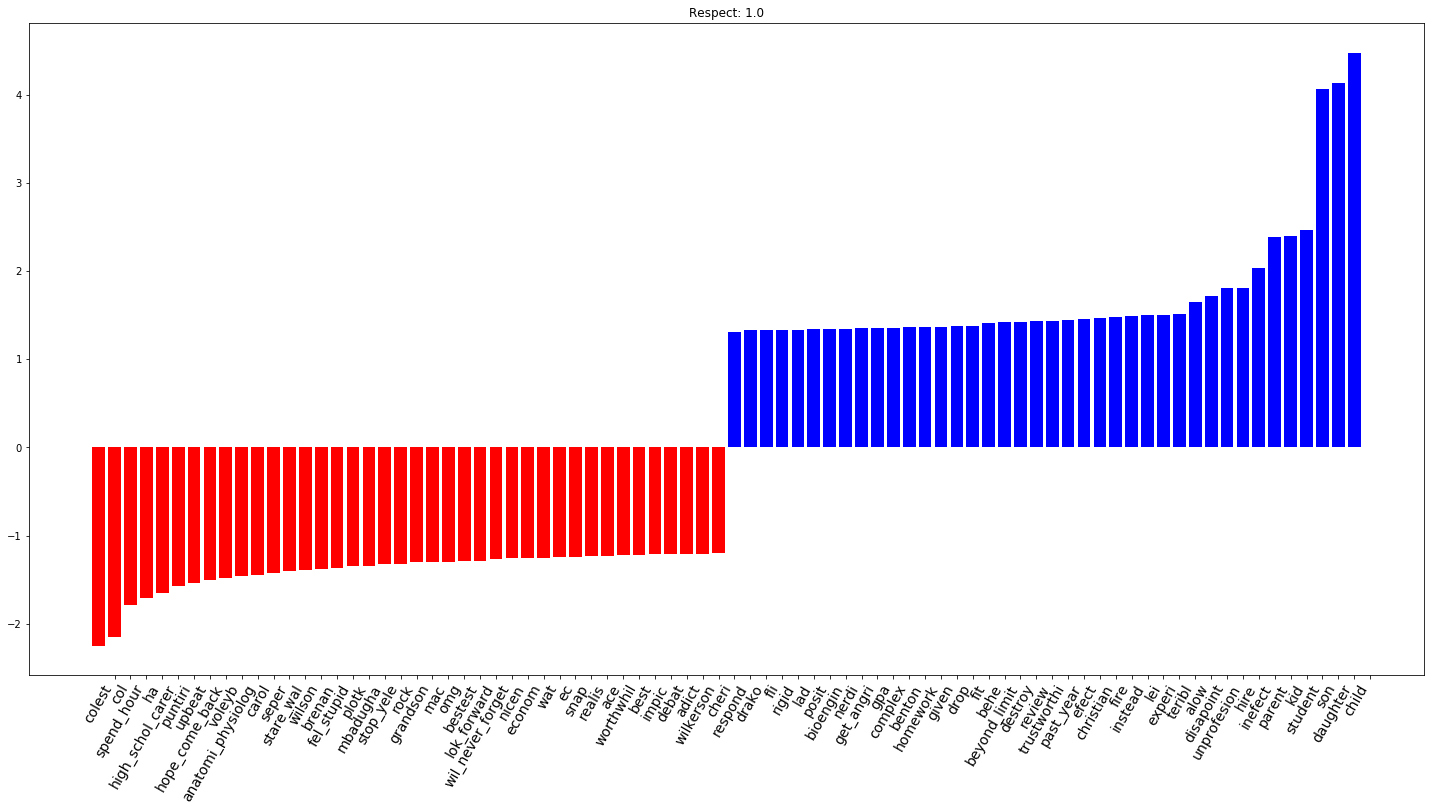

In [5]:
mt = reload(mt) 
vs = reload(vs)

# we loop through each index, get the text and create the label vector 
for k in label_dict: 
    for v in label_dict[k]:
        if v!=5: 
            # get the positive labeled text 
            docs = [text[idx] for idx in label_dict[k][v]]            

            # get the negative labeled text 
            docs = docs + [text[idx] for idx in negative_dict[k][v]]

            assert len(label_dict[k][v])==len(negative_dict[k][v])
            
            # create the label vector 
            labels = np.concatenate([np.ones(len(label_dict[k][v])),
                                     np.zeros(len(negative_dict[k][v]))])
            
            # train the svm model 
            results, svm, tfidf_vec = mt.run_svm(docs, 
                                                 labels)
            
            # set the title 
            title = str(k)+': '+str(v)
            # set the graph file name 
            graph = os.getcwd()+'/graphs/TFIDF Graphs/'+title+'.png'
            # visualize the top words or phrases that are predictive of each label 
            vs.plot_coefficients(results['coef'].values, 
                              results['word'].values, 
                              title,
                              top_features=40,
                              save=graph)             